In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import re
import time
import warnings
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE

## READING DATA

### Gene and Variation Data:

In [2]:
df = pd.read_csv('data/training_variants')
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
print('Features : ', df.columns.values)
df.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### Text Data:

In [3]:
textdata =pd.read_csv("data/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', textdata.shape[0])
print('Number of features : ', textdata.shape[1])
print('Features : ', textdata.columns.values)
textdata.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## TEXT PREPROCESSING

In [4]:
# loading stop words from nltk library
stop = set(stopwords.words('english'))

def nlp(txt, i, col):
    if type(txt) is not int:
        s = ""
        # replace every special char with space
        txt = re.sub('[^a-zA-Z0-9\n]', ' ', txt)
        # replace multiple spaces with single space
        txt = re.sub('\s+',' ', txt)
        # converting all the chars into lower-case.
        txt = txt.lower()
        
        for a in txt.split():
        # if the word is a not a stop word then retain that word from the data
            if not a in stop:
                s += a + " "
        
        textdata[col][i] = s

In [5]:
start = time.time()
for index, row in textdata.iterrows():
    if type(row['TEXT']) is str:
        nlp(row['TEXT'], index, 'TEXT')
    else:
        print("No text description for id:",index)
print('Text preprocessing time :',time.time() - start, "seconds")

No text description for id: 1109
No text description for id: 1277
No text description for id: 1407
No text description for id: 1639
No text description for id: 2755
Text preprocessing time : 22.650191068649292 seconds


In [6]:
#merging both gene_variations and text data based on their IDs
merged = pd.merge(df, textdata, on='ID', how='left')
merged.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
merged[merged.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
merged.loc[merged['TEXT'].isnull(),'TEXT'] = merged['Gene'] +' '+merged['Variation']
merged[merged['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## DATA SPLIT: TEST - TRAIN - CROSS VALIDATION

In [9]:
y_true = merged['Class'].values
merged.Gene      = merged.Gene.str.replace('\s+', '_')
merged.Variation = merged.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(merged, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [10]:
print('Number of points in training dataset:', train_df.shape[0])
print('Number of points in testing dataset:', test_df.shape[0])
print('Number of points in cross validation dataset:', cv_df.shape[0])

Number of points in training dataset: 2124
Number of points in testing dataset: 665
Number of points in cross validation dataset: 532


#### Yi distribution of the split data sets:

TRAINING SET:



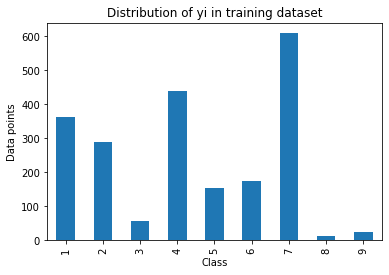

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)

TESTING SET:



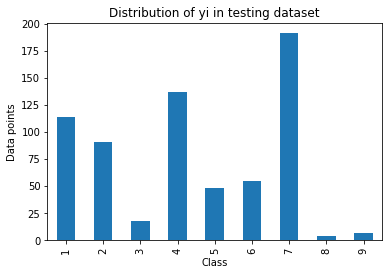

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)

CROSS VALIDATION SET:



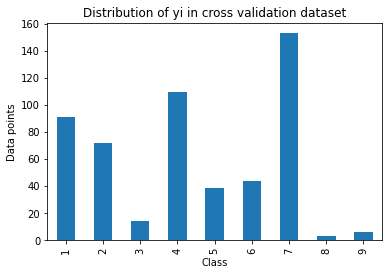

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [11]:
classdist_train = train_df['Class'].value_counts()
#cv_class_distribution = cv_df['Class'].value_counts().sortlevel()
# it returns a dict, keys as class labels and values as the number of data points in that class
classdist_train = train_df['Class'].value_counts().sort_index()
classdist_test = test_df['Class'].value_counts().sort_index()
classdist_cv = cv_df['Class'].value_counts().sort_index()

print("TRAINING SET:")
print("")
classdist_train.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points')
plt.title('Distribution of yi in training dataset')
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sort_yi = np.argsort(-classdist_train.values)
for i in sort_yi:
    print('Number of data points in class', i+1, ':',classdist_train.values[i], '(', np.round((classdist_train.values[i]/train_df.shape[0]*100), 3), '%)')
print("")
print("TESTING SET:")
print("")
classdist_test.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points')
plt.title('Distribution of yi in testing dataset')
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sort_yi = np.argsort(-classdist_test.values)
for i in sort_yi:
    print('Number of data points in class', i+1, ':',classdist_test.values[i], '(', np.round((classdist_test.values[i]/test_df.shape[0]*100), 3), '%)')

print("")
print("CROSS VALIDATION SET:")
print("")
classdist_cv.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points')
plt.title('Distribution of yi in cross validation dataset')
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sort_yi = np.argsort(-classdist_train.values)
for i in sort_yi:
    print('Number of data points in class', i+1, ':',classdist_cv.values[i], '(', np.round((classdist_cv.values[i]/cv_df.shape[0]*100), 3), '%)')


### Prediction using a 'Random' Model

#### Confusion Matrix:

In [12]:
def plot_heatmap(matrix,labels):
    plt.figure(figsize=(20,7))    
    sns.heatmap(matrix, annot=True, cmap="BuPu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def CM(y_test, y_predict):
    C = confusion_matrix(y_test, y_predict)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing in heatmap format
    print()
    print("Confusion matrix")
    plot_heatmap(C,labels)

    print("Precision matrix (Columm Sum=1)")
    plot_heatmap(B,labels)    
    
    print("Recall matrix (Row sum=1)")
    plot_heatmap(A,labels)


In a 'Random' Model, we generate the '9' class probabilites randomly such that they sum to 1.

Log loss on Cross Validation Data using Random Model 2.486334121257822
Log loss on Test Data using Random Model 2.477915057721836


Confusion matrix


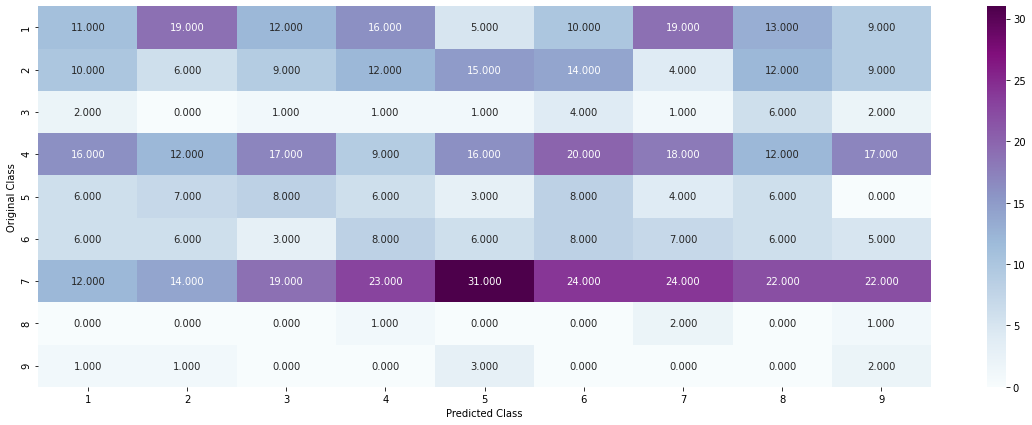

Precision matrix (Columm Sum=1)


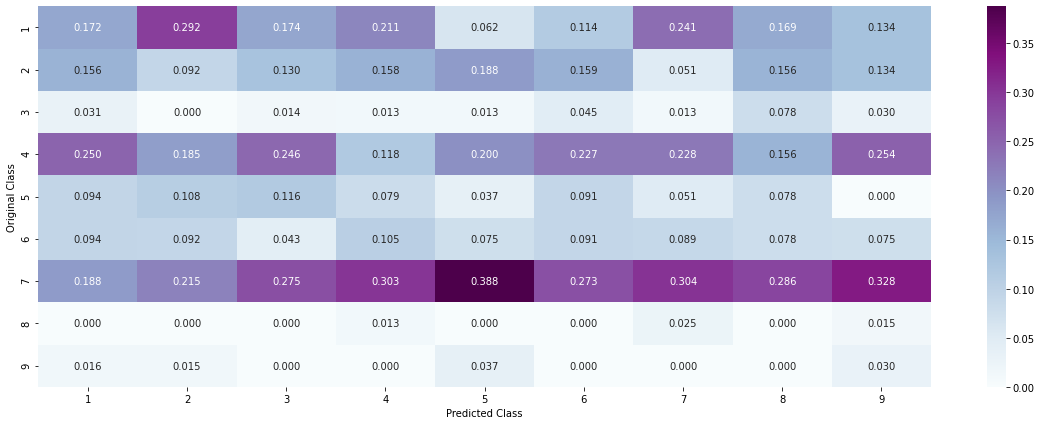

Recall matrix (Row sum=1)


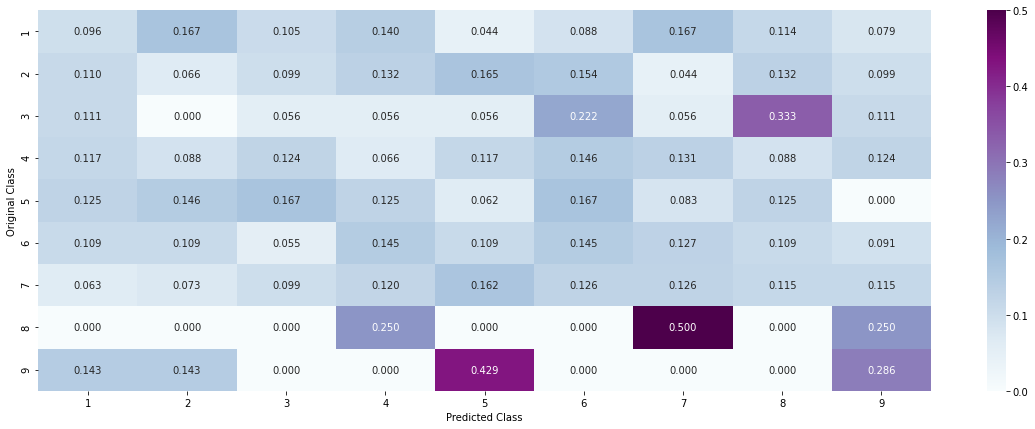

In [14]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_len = test_df.shape[0]
cv_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_pred_y = np.zeros((cv_len,9))
for i in range(cv_len):
    rand_probs = np.random.rand(1,9)
    cv_pred_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_pred_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_pred_y = np.zeros((test_len,9))
for i in range(test_len):
    rand_probs = np.random.rand(1,9)
    test_pred_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_pred_y, eps=1e-15))
print("")

predicted_y =np.argmax(test_pred_y, axis=1)
CM(y_test, predicted_y+1)

### UNIVARIATE ANALYSIS:

In [15]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_feature_dict(alpha, ft, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    val_ct = train_df[ft].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gvar_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, dr in val_ct.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[ft]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (dr + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gvar_dict[i]=vec
    return gvar_dict

# Get Gene variation feature
def get_feature(alpha, ft, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gvar_dict = get_feature_dict(alpha, ft, df)
    # value_count is similar in get_gv_fea_dict
    val_ct = train_df[ft].value_counts()
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_feat = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[ft] in dict(val_ct).keys():
            gv_feat.append(gvar_dict[row[ft]])
        else:
            gv_feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_feat

#### Univariate Analysis On Gene Feature:

In [16]:
g_unique = train_df['Gene'].value_counts()
print('Number of genes that are unique :', g_unique.shape[0])
# the top 10 genes that occured most
print(g_unique.head(10))

Number of genes that are unique : 233
BRCA1     166
TP53      107
EGFR      101
BRCA2      86
PTEN       83
KIT        58
BRAF       56
PDGFRA     46
ALK        43
ERBB2      42
Name: Gene, dtype: int64


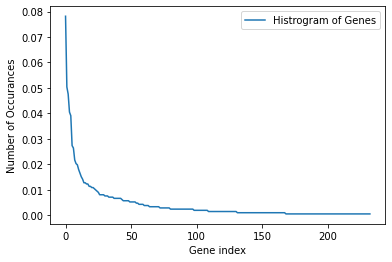

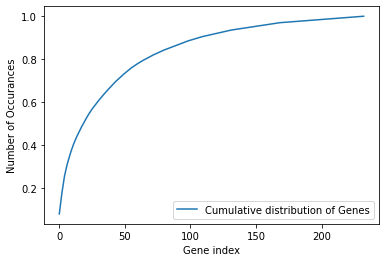

In [17]:
s = sum(g_unique.values);
h = g_unique.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Gene index')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.xlabel('Gene index')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

### Featurizing the gene feature:

In [18]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", cv_df))

In [19]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Building a logistic regression model using only Gene feature (one hot encoded) to predict y_i:

For alpha =  1e-05 , The log loss is: 1.2077395849259298
For alpha =  0.0001 , The log loss is: 1.1872864163688697
For alpha =  0.001 , The log loss is: 1.2365376843743263
For alpha =  0.01 , The log loss is: 1.3583067480869457
For alpha =  0.1 , The log loss is: 1.449174226809518
For alpha =  1 , The log loss is: 1.4827032625444185


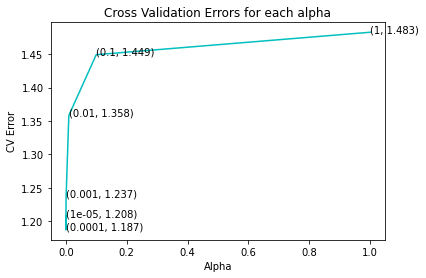

FOR BEST ALPHA VALUE =  0.0001

The train log loss is: 1.0038604693055146
The cross validation log loss is: 1.1872864163688697
The test log loss is: 1.1389931591321425


In [20]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For alpha = ', i, ", The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, text in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(text,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Errors for each alpha")
plt.xlabel("Alpha")
plt.ylabel("CV Error")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print("FOR BEST ALPHA VALUE = ", alpha[best_alpha])
print("")
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Univariate Analysis On Variation Feature:

In [21]:
var_unique = train_df['Variation'].value_counts()
print('Number of Unique Variations :', var_unique.shape[0])
# the top 10 variations that occured most
print(var_unique.head(10))

Number of Unique Variations : 1917
Truncating_Mutations    61
Deletion                50
Amplification           49
Fusions                 27
Overexpression           3
Q61R                     3
Q61H                     3
G12V                     2
R173C                    2
Y64A                     2
Name: Variation, dtype: int64


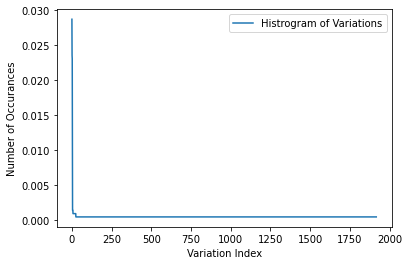

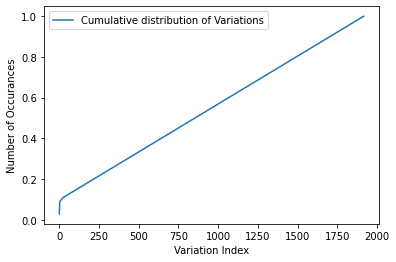

In [22]:
s = sum(var_unique.values);
h = var_unique.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Variation Index')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

c = np.cumsum(h)
#print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.xlabel('Variation Index')
plt.ylabel('Number of Occurances')
plt.legend()
plt.show()

In [23]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", cv_df))

In [24]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 , The log loss is: 1.6943475279062894
For values of alpha =  0.0001 , The log loss is: 1.6871854414140017
For values of alpha =  0.001 , The log loss is: 1.6906693850841186
For values of alpha =  0.01 , The log loss is: 1.7016346112755236
For values of alpha =  0.1 , The log loss is: 1.7134566427958404
For values of alpha =  1 , The log loss is: 1.7147479040475084


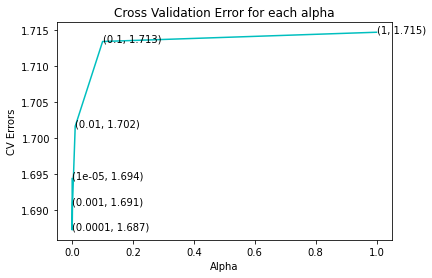

FOR BEST ALPHA VALUE =  0.0001

The train log loss is: 0.7116354564064145
The cross validation log loss is: 1.6871854414140017
The test log loss is: 1.735103507824477


In [25]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ", The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("CV Errors")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)
print("FOR BEST ALPHA VALUE = ", alpha[best_alpha])
print("")
predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Univariate Analysis On Text Feature:

In [26]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [27]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, min_tfidf=0.1, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [28]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
#train_text_features= text_vectorizer.get_feature_names()

# getting top 1000 feature names (words)
train_text_features = top_mean_feats(train_text_feature_onehotCoding,text_vectorizer.get_feature_names(),top_n=1000)['feature'].tolist()


# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [29]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [30]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [31]:
# https://stackoverflow.com/a/16202486

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

# normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.027903907193406827: 28, 0.06932938408217278: 16, 0.04117621953289685: 9, 0.020099406187554257: 8, 0.3472781605089648: 6, 0.04777849936233752: 6, 0.02988812542977875: 5, 0.2400733702500748: 4, 0.0823524390657937: 4, 0.038009682621373206: 4, 0.02483300095294046: 4, 0.01056315764391359: 4, 0.01015527281125837: 4, 0.09342326774732666: 3, 0.04431841704435685: 3, 0.03849816956656978: 3, 0.03707419455845582: 3, 0.01857383863666063: 3, 0.01785083211762867: 3, 0.011924654785588632: 3, 0.24745765195988786: 2, 0.1300812997039942: 2, 0.12352865859869057: 2, 0.07091390953791062: 2, 0.06544223085392778: 2, 0.06361791631644118: 2, 0.05854415949749135: 2, 0.05582658229268081: 2, 0.052840065289111275: 2, 0.051525949954303776: 2, 0.04943886016598386: 2, 0.04376302766070517: 2, 0.0415576482091425: 2, 0.031198507370574717: 2, 0.02643024209905131: 2, 0.025505925043190044: 2, 0.02493367571338566: 2, 0.02287775285583013: 2, 0.022739181215512994: 2, 0.02203175302094371: 2, 0.02177110835112084: 2, 0

For values of alpha =  1e-05 , The log loss is: 1.2203956901957396
For values of alpha =  0.0001 , The log loss is: 1.0832393477241555
For values of alpha =  0.001 , The log loss is: 1.1000061514734194
For values of alpha =  0.01 , The log loss is: 1.245721265225539
For values of alpha =  0.1 , The log loss is: 1.3088308447557546
For values of alpha =  1 , The log loss is: 1.4505294502330972


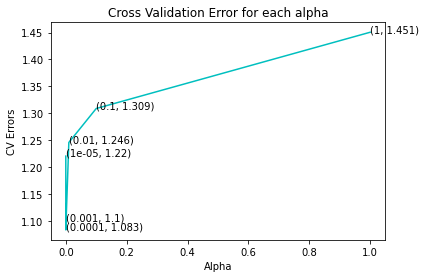

FOR BEST ALPHA VALUE =  0.0001

The train log loss is: 0.6038863655216327
The cross validation log loss is: 1.0832393477241555
0.0001 The test log loss is: 1.1066527897314933


In [32]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ", The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("CV Errors")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)
print("FOR BEST ALPHA VALUE = ", alpha[best_alpha])
print("")
predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print(alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [33]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

2.866 % of word of test data appeared in train data
3.193 % of word of Cross Validation appeared in train data


## VARIOUS MACHINE LEARNING MODELS:

In [34]:
# function to plot the Confusion Matrix
def plot_CM(train_x, train_y,test_x, test_y, classifier):
    classifier.fit(train_x, train_y)
    sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x, train_y)
    y_pred = sigmoid_classifier.predict(test_x)

    print("Log loss = ",log_loss(test_y, sigmoid_classifier.predict_proba(test_x)))
    print("Points that were mis-classified :", np.count_nonzero((y_pred- test_y))/test_y.shape[0])
    CM(test_y, y_pred)

In [35]:
# We will be printing the features and checking if these are present in the text point or not.
# Naive Bayes will use this function

def get_ftnames(i, text, gene, var, n):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vector = gene_count_vec.fit(train_df['Gene'])
    var_vector  = var_count_vec.fit(train_df['Variation'])
    text_vector = text_count_vec.fit(train_df['TEXT'])
    
    ft1_len = len(gene_vector.get_feature_names())
    ft2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for j,vec in enumerate(i):
        if (vec < ft1_len):
            word = gene_vector.get_feature_names()[vec]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(j, "The gene feature here is [{}] present in the data point[{}]".format(word,yes_no))
        elif (vec < ft1_len+ft2_len):
            word = var_vector.get_feature_names()[vec-(ft1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(j, " The variation feature here is [{}] present in the test data point [{}]".format(word,yes_no))
        else:
            word = text_vector.get_feature_names()[vec-(ft1_len+ft2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(j, "Text feature here is[{}] present in the test data point [{}]".format(word,yes_no))

    print("At the query point",n," number of features and word ", word_present)

#### STACK ALL THREE FEATURES:

In [36]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [37]:
print("ONE HOT ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_onehotCoding.shape)
print("Test dataset = ", test_x_onehotCoding.shape)
print("Cross Validation dataset =", cv_x_onehotCoding.shape)
print("")
print("RESPONSE ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_responseCoding.shape)
print("Test dataset = ", test_x_responseCoding.shape)
print("Cross Validation dataset =", cv_x_responseCoding.shape)

ONE HOT ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 56142)
Test dataset =  (665, 56142)
Cross Validation dataset = (532, 56142)

RESPONSE ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 27)
Test dataset =  (665, 27)
Cross Validation dataset = (532, 27)


### NAIVE BAYES:

alpha =  1e-05
Log Loss =  1.261539168471148

alpha =  0.0001
Log Loss =  1.2597834342180505

alpha =  0.001
Log Loss =  1.2475541449290857

alpha =  0.1
Log Loss =  1.2253733327891567

alpha =  1
Log Loss =  1.2788447988471918

alpha =  10
Log Loss =  1.3800685786938478

alpha =  100
Log Loss =  1.3190743700239247

alpha =  1000
Log Loss =  1.2582383756474387



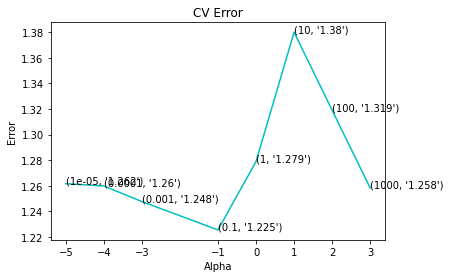

For values of best alpha =  0.1

The train log loss is  0.8405792308823752
The cross validation log loss is  1.2253733327891567
The test log loss is  1.2788461827274915


In [38]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("alpha = ", i)
    classifier = MultinomialNB(alpha=i)
    classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss = ",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.xticks(np.log10(alpha))
plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
classifier = MultinomialNB(alpha=alpha[best_alpha])
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)

print('For values of best alpha = ', alpha[best_alpha])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_onehotCoding)
print("The train log loss is ",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is ",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_onehotCoding)
print("The test log loss is ",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))

TESTING MODEL FOR BEST ALPHA:

Log Loss : 1.0274755306490486
Number of missclassified point : 0.3308270676691729

Confusion matrix


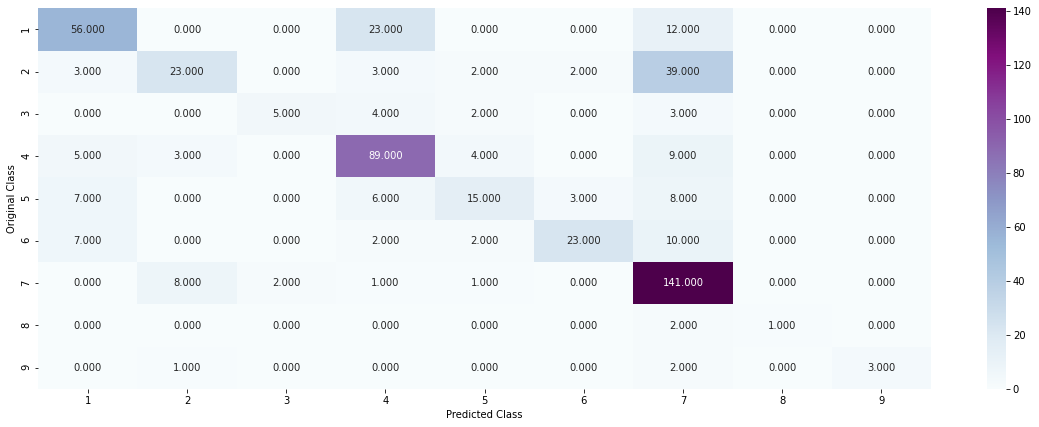

Precision matrix (Columm Sum=1)


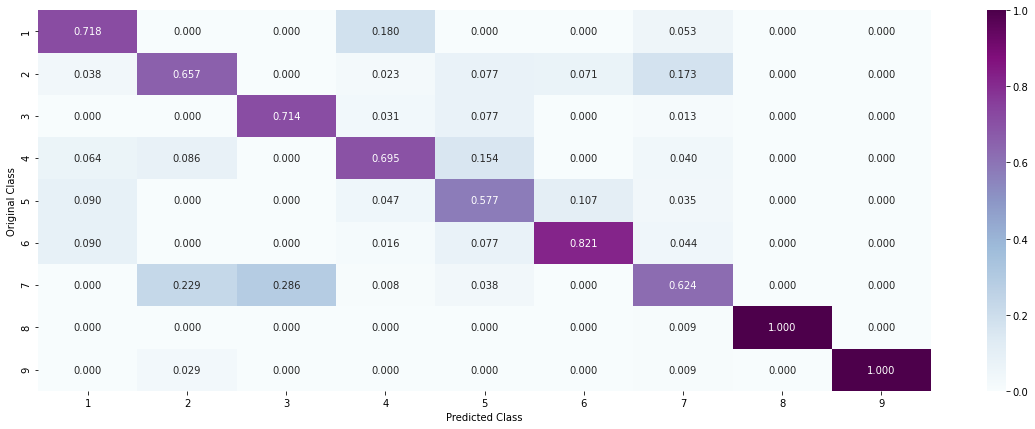

Recall matrix (Row sum=1)


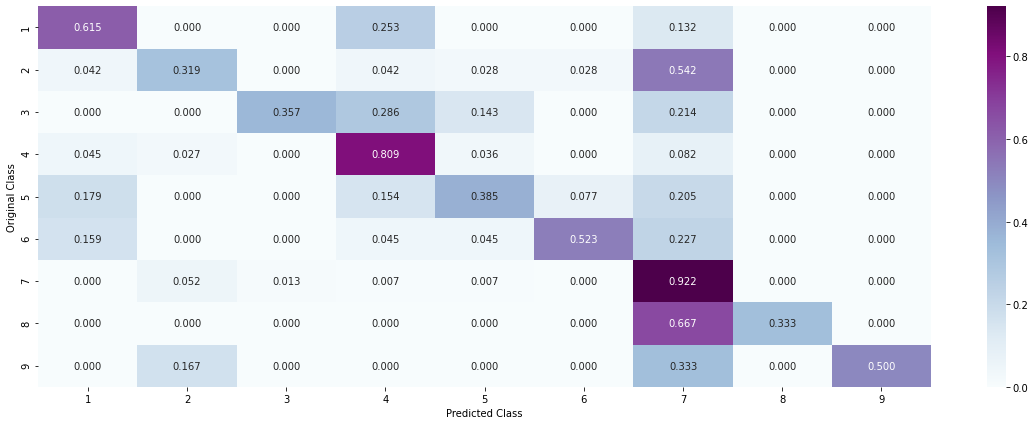

In [39]:
#find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

classifier = MultinomialNB(alpha=alpha[best_alpha])
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(clf, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs))
print("Number of missclassified point :", np.count_nonzero((sigmoid_classifier.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
CM(cv_y, sigmoid_classifier.predict(cv_x_onehotCoding.toarray()))


##### Feature Importance, Correctly classified points


In [40]:
test_point_index = 1
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 1
Predicted Class Probabilities: [[6.019e-01 1.340e-02 8.000e-04 1.631e-01 1.831e-01 1.950e-02 1.190e-02
  5.500e-03 6.000e-04]]
Actual Class : 1

11 Text feature here is[protein] present in the test data point [True]
12 Text feature here is[type] present in the test data point [True]
13 Text feature here is[dna] present in the test data point [True]
15 Text feature here is[one] present in the test data point [True]
16 Text feature here is[wild] present in the test data point [True]
17 Text feature here is[involved] present in the test data point [True]
18 Text feature here is[containing] present in the test data point [True]
19 Text feature here is[results] present in the test data point [True]
20 Text feature here is[therefore] present in the test data point [True]
21 Text feature here is[two] present in the test data point [True]
22 Text feature here is[binding] present in the test data point [True]
23 Text feature here is[region] present in the test data point [Tr

139 Text feature here is[interact] present in the test data point [True]
140 Text feature here is[whereas] present in the test data point [True]
141 Text feature here is[significant] present in the test data point [True]
142 Text feature here is[performed] present in the test data point [True]
143 Text feature here is[30] present in the test data point [True]
144 Text feature here is[identify] present in the test data point [True]
145 Text feature here is[materials] present in the test data point [True]
147 Text feature here is[additional] present in the test data point [True]
148 Text feature here is[increased] present in the test data point [True]
149 Text feature here is[structural] present in the test data point [True]
150 Text feature here is[indicates] present in the test data point [True]
151 Text feature here is[http] present in the test data point [True]
152 Text feature here is[expressed] present in the test data point [True]
153 Text feature here is[different] present in the

281 Text feature here is[detailed] present in the test data point [True]
282 Text feature here is[scale] present in the test data point [True]
283 Text feature here is[80] present in the test data point [True]
284 Text feature here is[polymerase] present in the test data point [True]
285 Text feature here is[amount] present in the test data point [True]
286 Text feature here is[negative] present in the test data point [True]
288 Text feature here is[detected] present in the test data point [True]
289 Text feature here is[occurs] present in the test data point [True]
290 Text feature here is[4b] present in the test data point [True]
291 Text feature here is[showed] present in the test data point [True]
293 Text feature here is[population] present in the test data point [True]
294 Text feature here is[definition] present in the test data point [True]
295 Text feature here is[less] present in the test data point [True]
296 Text feature here is[moreover] present in the test data point [Tru

442 Text feature here is[area] present in the test data point [True]
443 Text feature here is[residue] present in the test data point [True]
444 Text feature here is[include] present in the test data point [True]
445 Text feature here is[functionally] present in the test data point [True]
446 Text feature here is[activity] present in the test data point [True]
447 Text feature here is[carrying] present in the test data point [True]
449 Text feature here is[markedly] present in the test data point [True]
450 Text feature here is[transcribed] present in the test data point [True]
451 Text feature here is[risk] present in the test data point [True]
452 Text feature here is[facilitates] present in the test data point [True]
454 Text feature here is[www] present in the test data point [True]
455 Text feature here is[ref] present in the test data point [True]
456 Text feature here is[recognition] present in the test data point [True]
457 Text feature here is[disruption] present in the test d

606 Text feature here is[various] present in the test data point [True]
609 Text feature here is[53] present in the test data point [True]
610 Text feature here is[reduction] present in the test data point [True]
614 Text feature here is[public] present in the test data point [True]
616 Text feature here is[rna] present in the test data point [True]
621 Text feature here is[database] present in the test data point [True]
624 Text feature here is[especially] present in the test data point [True]
626 Text feature here is[evaluated] present in the test data point [True]
628 Text feature here is[perhaps] present in the test data point [True]
629 Text feature here is[showing] present in the test data point [True]
630 Text feature here is[overall] present in the test data point [True]
631 Text feature here is[integrity] present in the test data point [True]
632 Text feature here is[lead] present in the test data point [True]
633 Text feature here is[nonspecific] present in the test data poin

793 Text feature here is[elastase] present in the test data point [True]
798 Text feature here is[quantitative] present in the test data point [True]
799 Text feature here is[unlikely] present in the test data point [True]
800 Text feature here is[solvent] present in the test data point [True]
801 Text feature here is[introducing] present in the test data point [True]
803 Text feature here is[powerpoint] present in the test data point [True]
805 Text feature here is[bands] present in the test data point [True]
807 Text feature here is[34] present in the test data point [True]
809 Text feature here is[calorimetry] present in the test data point [True]
811 Text feature here is[titration] present in the test data point [True]
812 Text feature here is[potentially] present in the test data point [True]
816 Text feature here is[isothermal] present in the test data point [True]
817 Text feature here is[preponderance] present in the test data point [True]
818 Text feature here is[image] presen

##### Feature Importance, Incorrectly classified points

In [41]:
test_point_index = 5
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[2.900e-03 3.200e-03 2.000e-04 9.816e-01 2.900e-03 6.000e-04 7.000e-04
  7.700e-03 1.000e-04]]
Actual Class : 4

9 Text feature here is[proteins] present in the test data point [True]
10 Text feature here is[activity] present in the test data point [True]
11 Text feature here is[protein] present in the test data point [True]
14 Text feature here is[experiments] present in the test data point [True]
15 Text feature here is[indicated] present in the test data point [True]
16 Text feature here is[shown] present in the test data point [True]
17 Text feature here is[function] present in the test data point [True]
18 Text feature here is[whereas] present in the test data point [True]
19 Text feature here is[acid] present in the test data point [True]
20 Text feature here is[determined] present in the test data point [True]
21 Text feature here is[mammalian] present in the test data point [True]
22 Text feature here is[whether] present in th

146 Text feature here is[scanning] present in the test data point [True]
147 Text feature here is[suggested] present in the test data point [True]
148 Text feature here is[acids] present in the test data point [True]
149 Text feature here is[amount] present in the test data point [True]
151 Text feature here is[rather] present in the test data point [True]
152 Text feature here is[discussion] present in the test data point [True]
153 Text feature here is[critical] present in the test data point [True]
154 Text feature here is[derived] present in the test data point [True]
156 Text feature here is[system] present in the test data point [True]
157 Text feature here is[key] present in the test data point [True]
159 Text feature here is[together] present in the test data point [True]
160 Text feature here is[affected] present in the test data point [True]
161 Text feature here is[fact] present in the test data point [True]
162 Text feature here is[except] present in the test data point [Tr

295 Text feature here is[sg] present in the test data point [True]
296 Text feature here is[material] present in the test data point [True]
297 Text feature here is[phosphate] present in the test data point [True]
299 Text feature here is[provide] present in the test data point [True]
300 Text feature here is[remains] present in the test data point [True]
302 Text feature here is[part] present in the test data point [True]
306 Text feature here is[test] present in the test data point [True]
307 Text feature here is[assayed] present in the test data point [True]
308 Text feature here is[antibody] present in the test data point [True]
309 Text feature here is[majority] present in the test data point [True]
312 Text feature here is[catalysis] present in the test data point [True]
316 Text feature here is[permissive] present in the test data point [True]
317 Text feature here is[assay] present in the test data point [True]
319 Text feature here is[blue] present in the test data point [True

561 Text feature here is[necessary] present in the test data point [True]
562 Text feature here is[level] present in the test data point [True]
563 Text feature here is[stability] present in the test data point [True]
564 Text feature here is[region] present in the test data point [True]
566 Text feature here is[highly] present in the test data point [True]
570 Text feature here is[induced] present in the test data point [True]
572 Text feature here is[significant] present in the test data point [True]
573 Text feature here is[s1] present in the test data point [True]
574 Text feature here is[single] present in the test data point [True]
575 Text feature here is[followed] present in the test data point [True]
576 Text feature here is[make] present in the test data point [True]
577 Text feature here is[stained] present in the test data point [True]
578 Text feature here is[assessment] present in the test data point [True]
580 Text feature here is[acetone] present in the test data point 

735 Text feature here is[form] present in the test data point [True]
736 Text feature here is[association] present in the test data point [True]
738 Text feature here is[suggests] present in the test data point [True]
739 Text feature here is[pbs] present in the test data point [True]
740 Text feature here is[1c] present in the test data point [True]
743 Text feature here is[agarose] present in the test data point [True]
747 Text feature here is[life] present in the test data point [True]
748 Text feature here is[versions] present in the test data point [True]
756 Text feature here is[sites] present in the test data point [True]
757 Text feature here is[p3] present in the test data point [True]
758 Text feature here is[investigated] present in the test data point [True]
763 Text feature here is[central] present in the test data point [True]
764 Text feature here is[yet] present in the test data point [True]
765 Text feature here is[alignment] present in the test data point [True]
766 T

937 Text feature here is[upon] present in the test data point [True]
938 Text feature here is[corresponding] present in the test data point [True]
940 Text feature here is[groups] present in the test data point [True]
941 Text feature here is[confirm] present in the test data point [True]
942 Text feature here is[ptdins] present in the test data point [True]
945 Text feature here is[precipitated] present in the test data point [True]
981 Text feature here is[substitution] present in the test data point [True]
983 Text feature here is[measure] present in the test data point [True]
985 Text feature here is[plus] present in the test data point [True]
988 Text feature here is[report] present in the test data point [True]
989 Text feature here is[isolated] present in the test data point [True]
991 Text feature here is[model] present in the test data point [True]
992 Text feature here is[inactive] present in the test data point [True]
993 Text feature here is[3a] present in the test data poi

## KNN 

alpha = 5
Log Loss =  1.048855853257669

alpha = 11
Log Loss =  1.026835331239107

alpha = 15
Log Loss =  1.031354068635507

alpha = 21
Log Loss =  1.0283607829316317

alpha = 31
Log Loss =  1.0436573129611595

alpha = 41
Log Loss =  1.0492527362191204

alpha = 51
Log Loss =  1.0638058134308201

alpha = 99
Log Loss =  1.0974814915387896



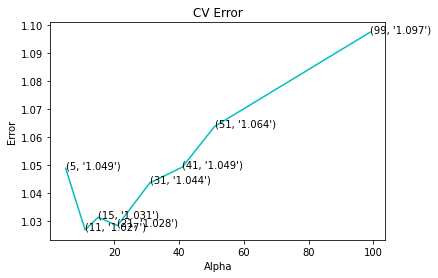

For values of best alpha =  11

The train log loss is  0.6134764791660455
The cross validation log loss is: 1.026835331239107
The test log loss is: 1.0506740367299763


In [42]:
#KNN
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("alpha =", i)
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_x_responseCoding, train_y)
    sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x_responseCoding, train_y)
    sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss = ",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
classifier = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
classifier.fit(train_x_responseCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_responseCoding, train_y)

print('For values of best alpha = ', alpha[best_alpha])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_responseCoding)
print("The train log loss is ",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_responseCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_responseCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss =  1.026835331239107
Points that were mis-classified : 0.35714285714285715

Confusion matrix


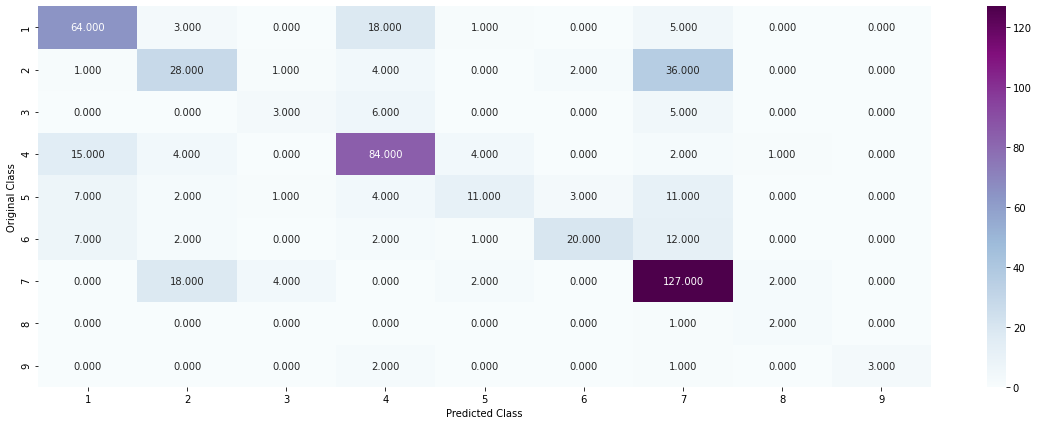

Precision matrix (Columm Sum=1)


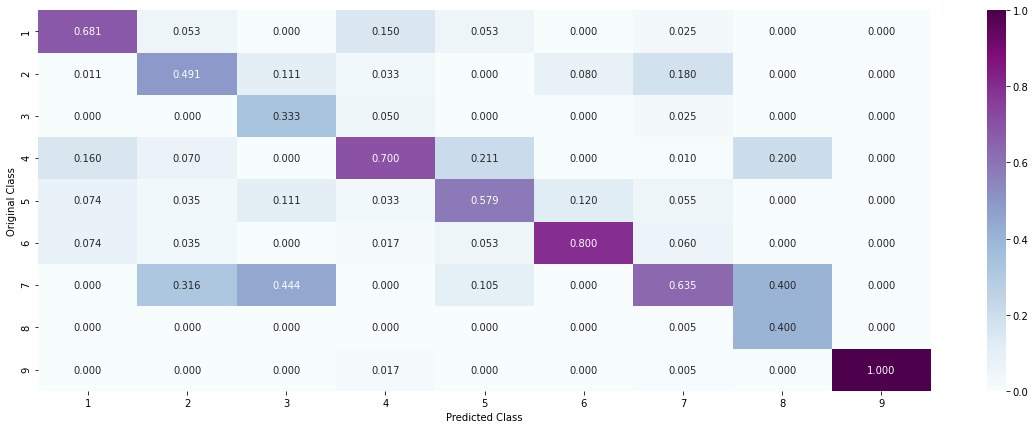

Recall matrix (Row sum=1)


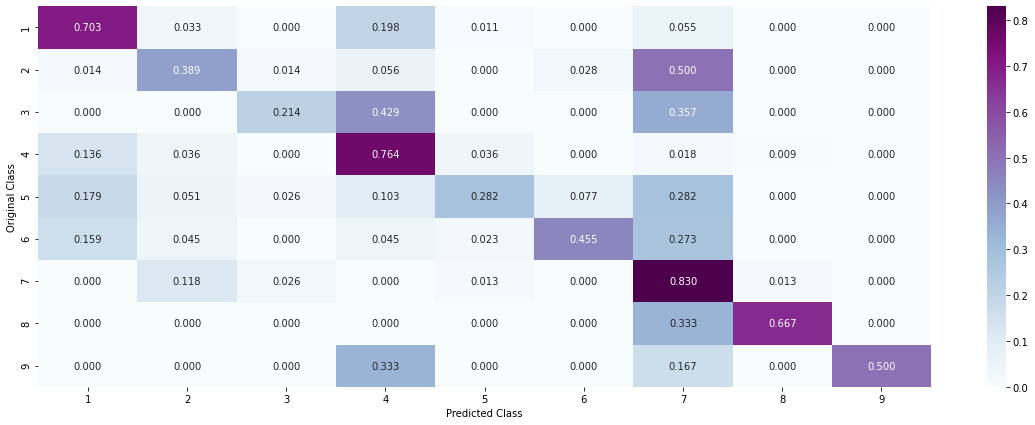

In [43]:
#TESTING
classifier = KNeighborsClassifier(n_neighbors=(alpha[best_alpha]))
plot_CM(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, classifier)

##### SAMPLE QUERY

##### Feature Importance, Correctly classified points


In [44]:
classifier = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
classifier.fit(train_x_responseCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_class = sigmoid_classifier.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_class[0])
print("Actual Class :", test_y[test_point_index])
neighbors = classifier.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 1
The  11  nearest neighbours of the test points belongs to classes [1 1 1 1 1 5 5 5 5 5 5]
Fequency of nearest points : Counter({5: 6, 1: 5})


##### Feature Importance, Incorrectly classified points


In [45]:
classifier = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
classifier.fit(train_x_responseCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_responseCoding, train_y)

test_point_index = 5
predicted_class = sigmoid_classifier.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_class[0])
print("Actual Class :", test_y[test_point_index])
neighbors = classifier.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 3 4 4 4]
Fequency of nearest points : Counter({4: 10, 3: 1})


## LOGISTIC REGRESSION (With Class Balancing)

alpha = 1e-06
Log Loss : 1.197353908876478

alpha = 1e-05
Log Loss : 1.1622776769414185

alpha = 0.0001
Log Loss : 1.0164104239233065

alpha = 0.001
Log Loss : 1.0109406280732736

alpha = 0.01
Log Loss : 1.078641101623097

alpha = 0.1
Log Loss : 1.1845964759841459

alpha = 1
Log Loss : 1.3983094961687796

alpha = 10
Log Loss : 1.4425954599690956

alpha = 100
Log Loss : 1.4475986118806756



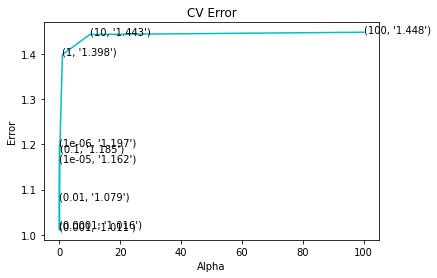

For values of best alpha =  0.001

The train log loss is: 0.4845677880936913
The cross validation log loss is: 1.0109406280732736
The test log loss is: 1.0737928652363105


In [46]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("alpha =", i)
    classifier = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
classifier = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)

print('For values of best alpha = ', alpha[best_alpha])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))


Log loss =  1.0109406280732736
Points that were mis-classified : 0.33270676691729323

Confusion matrix


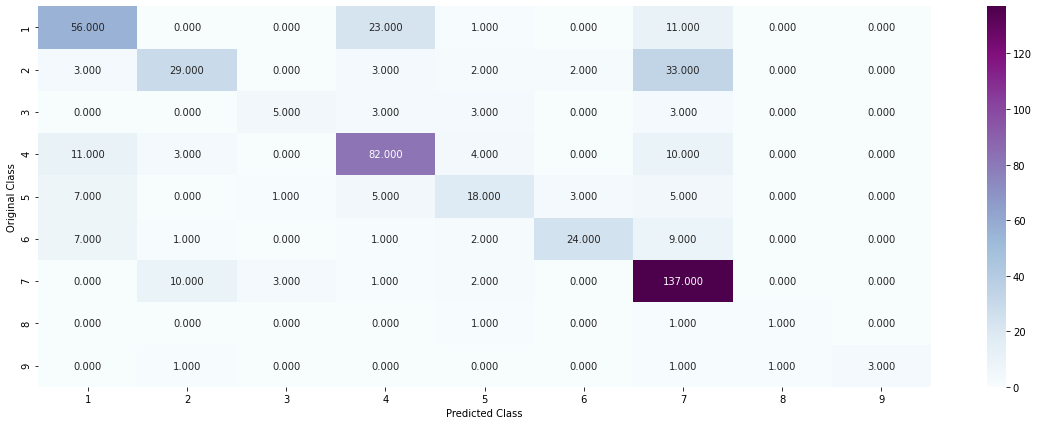

Precision matrix (Columm Sum=1)


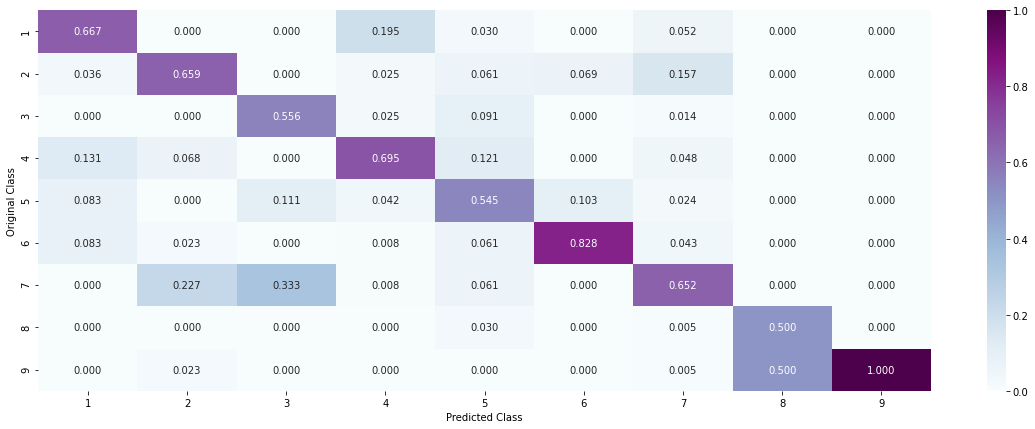

Recall matrix (Row sum=1)


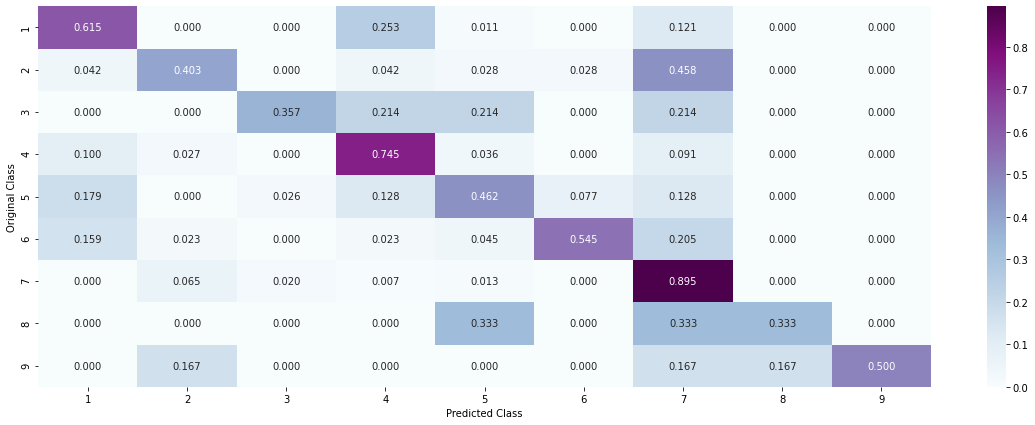

In [47]:
#TESTING
classifier = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
plot_CM(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, classifier)


##### Feature Importance, Correctly classified points


In [48]:
#CORRECTLY CLASSIFIED
classifier = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
classifier.fit(train_x_onehotCoding,train_y)
test_point_index = 1
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 1
Predicted Class Probabilities: [[6.707e-01 2.400e-03 6.000e-04 2.340e-02 2.770e-01 1.830e-02 1.000e-03
  5.500e-03 1.100e-03]]
Actual Class : 1

286 Text feature here is[xrcc1] present in the test data point [True]
460 Text feature here is[absolutely] present in the test data point [True]
583 Text feature here is[mapping] present in the test data point [True]
584 Text feature here is[elastase] present in the test data point [True]
601 Text feature here is[chymotrypsin] present in the test data point [True]
800 Text feature here is[repeats] present in the test data point [True]
831 Text feature here is[unfolded] present in the test data point [True]
855 Text feature here is[destabilized] present in the test data point [True]
954 Text feature here is[genbank] present in the test data point [True]
973 Text feature here is[immobilized] present in the test data point [True]
999 Text feature here is[folded] present in the test data point [True]
At the query point 1000  nu

##### Feature Importance, Incorrectly classified points


In [49]:
#INCORRECTLY CLASSIFIED
test_point_index = 5
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[6.000e-04 1.400e-03 1.000e-04 9.817e-01 1.300e-03 4.000e-04 8.600e-03
  5.400e-03 4.000e-04]]
Actual Class : 4

134 Text feature here is[devoid] present in the test data point [True]
163 Text feature here is[erbitux] present in the test data point [True]
195 Text feature here is[suppressor] present in the test data point [True]
214 Text feature here is[degradation] present in the test data point [True]
258 Text feature here is[instability] present in the test data point [True]
266 Text feature here is[279] present in the test data point [True]
432 Text feature here is[p15ink4b] present in the test data point [True]
450 Text feature here is[p70s6k] present in the test data point [True]
472 Text feature here is[ninhydrin] present in the test data point [True]
489 Text feature here is[predisposed] present in the test data point [True]
501 Text feature here is[come] present in the test data point [True]
509 Text feature here is[mci] pres

## LOGISTIC REGRESSION (Without Class Balncing)

alpha = 1e-06
Log Loss : 1.1888171170845552

alpha = 1e-05
Log Loss : 1.1401537457868658

alpha = 0.0001
Log Loss : 1.0274755306490486

alpha = 0.001
Log Loss : 1.0337658914589976

alpha = 0.01
Log Loss : 1.17232082901254

alpha = 0.1
Log Loss : 1.2559325937608357

alpha = 1
Log Loss : 1.380619448835299



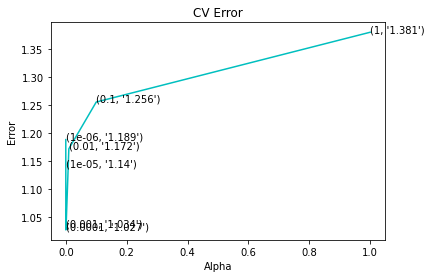

For values of best alpha =  0.0001

The train log loss is: 0.44705223363105234
The cross validation log loss is: 1.0274755306490486
The test log loss is: 1.0767148884021793


In [50]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("alpha =", i)
    classifier = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier= CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

print('For values of best alpha = ', alpha[best_alpha])
print("")
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))


Log loss =  1.0274755306490486
Points that were mis-classified : 0.3308270676691729

Confusion matrix


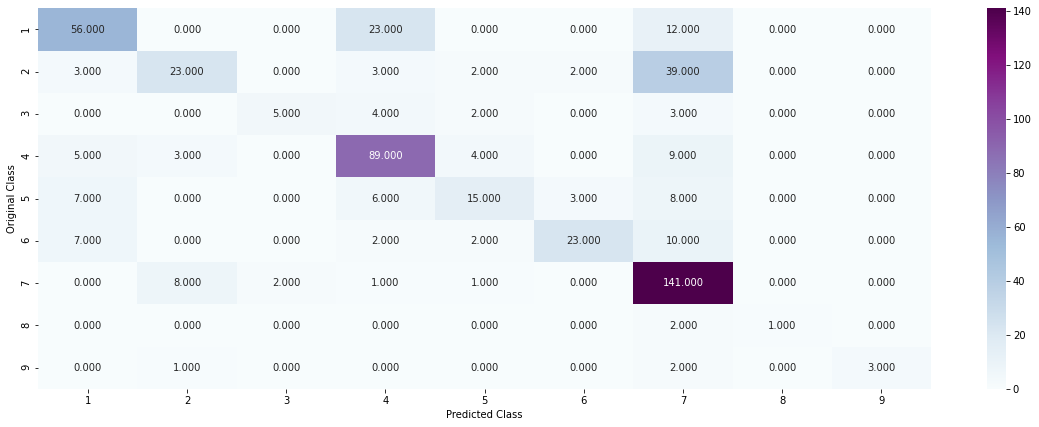

Precision matrix (Columm Sum=1)


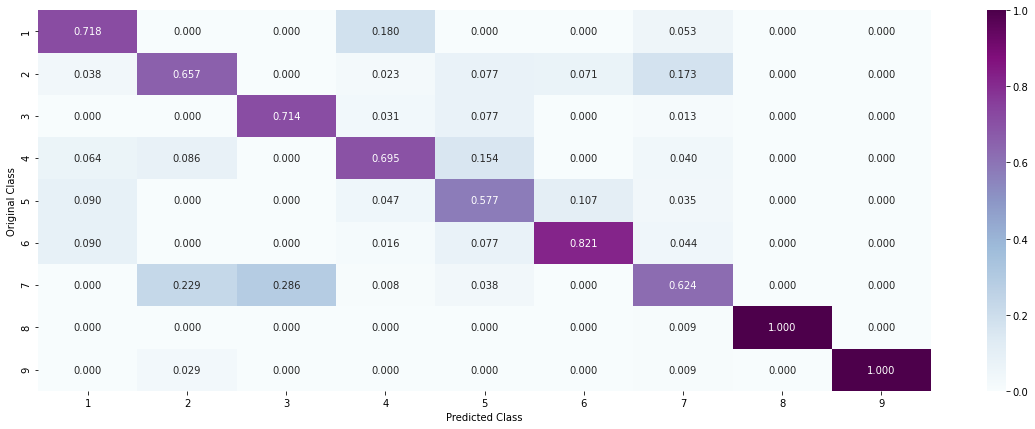

Recall matrix (Row sum=1)


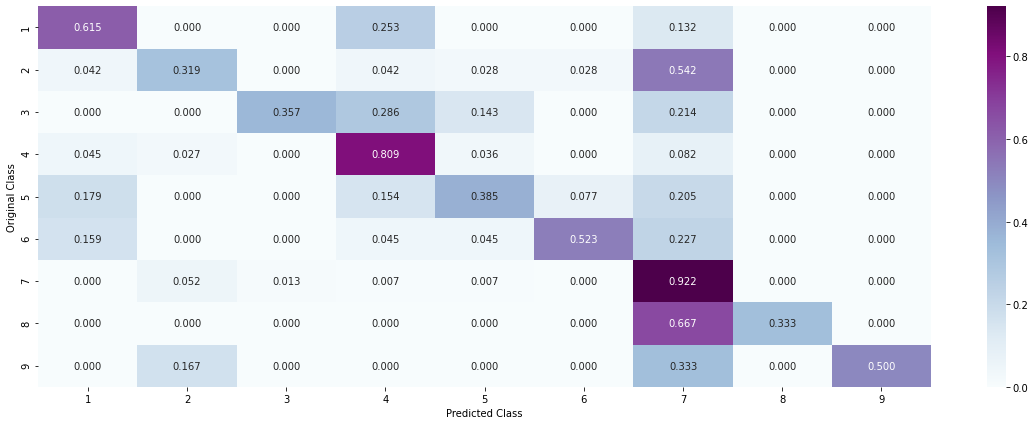

In [51]:
classifier = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
plot_CM(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, classifier)


##### Feature Importance, Correctly classified points


In [52]:
classifier = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
classifier.fit(train_x_onehotCoding,train_y)
test_point_index = 1
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 5
Predicted Class Probabilities: [[0.3597 0.0878 0.0546 0.0366 0.3662 0.0129 0.0007 0.0774 0.004 ]]
Actual Class : 1

410 Text feature here is[lexa] present in the test data point [True]
619 Text feature here is[operator] present in the test data point [True]
691 Text feature here is[effort] present in the test data point [True]
754 Text feature here is[v1833m] present in the test data point [True]
766 Text feature here is[likelihood] present in the test data point [True]
792 Text feature here is[pathogenicity] present in the test data point [True]
861 Text feature here is[r1699q] present in the test data point [True]
867 Text feature here is[classifying] present in the test data point [True]
891 Text feature here is[brca2] present in the test data point [True]
At the query point 1000  number of features and word  9


##### Feature Importance, Incorrectly classified points


In [53]:
test_point_index = 5
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[2.01e-02 3.53e-02 3.04e-02 7.61e-01 5.87e-02 5.00e-04 7.00e-04 9.25e-02
  7.00e-04]]
Actual Class : 4

248 Text feature here is[erbitux] present in the test data point [True]
305 Text feature here is[araf] present in the test data point [True]
327 Text feature here is[mobilization] present in the test data point [True]
343 Text feature here is[neighbours] present in the test data point [True]
379 Text feature here is[surely] present in the test data point [True]
390 Text feature here is[devoid] present in the test data point [True]
410 Text feature here is[homologues] present in the test data point [True]
440 Text feature here is[ninhydrin] present in the test data point [True]
444 Text feature here is[279] present in the test data point [True]
451 Text feature here is[degradation] present in the test data point [True]
486 Text feature here is[come] present in the test data point [True]
487 Text feature here is[suppressor] present in

## LINEAR SVM

C = 1e-05
Log Loss : 1.176743727336208

C = 0.0001
Log Loss : 1.1021238158118714

C = 0.001
Log Loss : 1.0322979645756296

C = 0.01
Log Loss : 1.087234207921796

C = 0.1
Log Loss : 1.2227619297268244

C = 1
Log Loss : 1.448796627681466

C = 10
Log Loss : 1.4485076150740133

C = 100
Log Loss : 1.4485075839685797



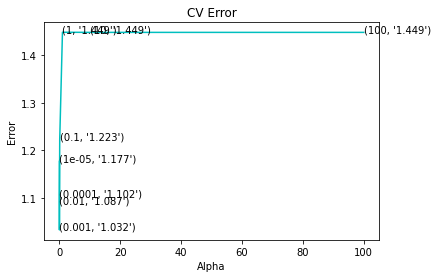

For values of best alpha =  0.001

The train log loss is: 0.44705223363105234
The cross validation log loss is: 1.0274755306490486
The test log loss is: 1.0767148884021793


In [54]:
#LINEAR SVM
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("C =", i)
    classifier = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
    sigmoid_classifier.fit(train_x_onehotCoding, train_y)
    sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
classifier = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(clf, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)

print('For values of best alpha = ', alpha[best_alpha])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))

Log loss =  1.0322979645756296
Points that were mis-classified : 0.3176691729323308

Confusion matrix


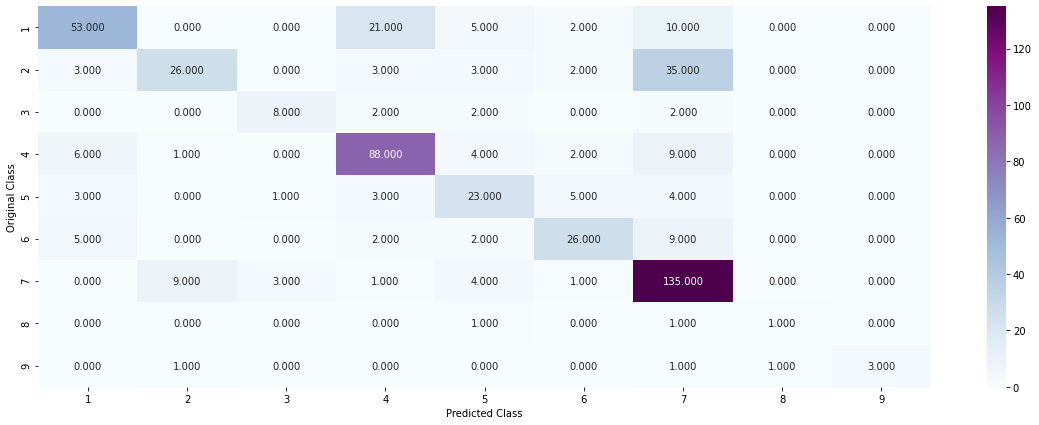

Precision matrix (Columm Sum=1)


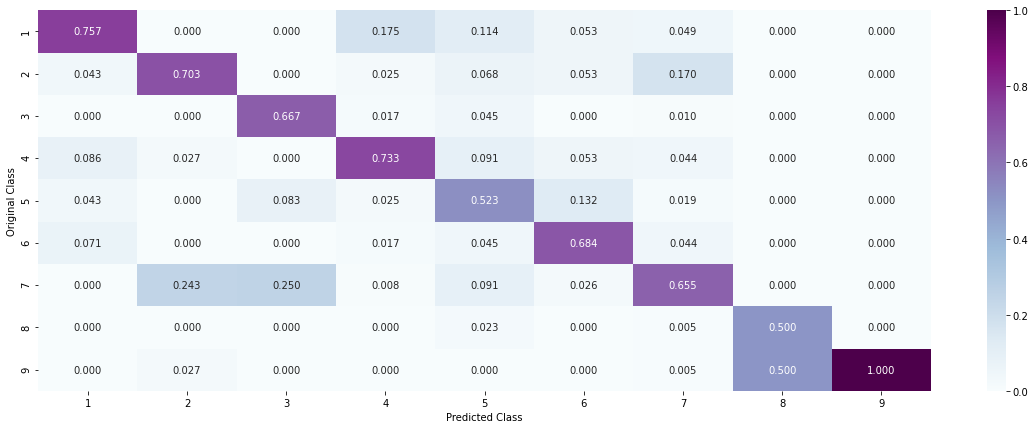

Recall matrix (Row sum=1)


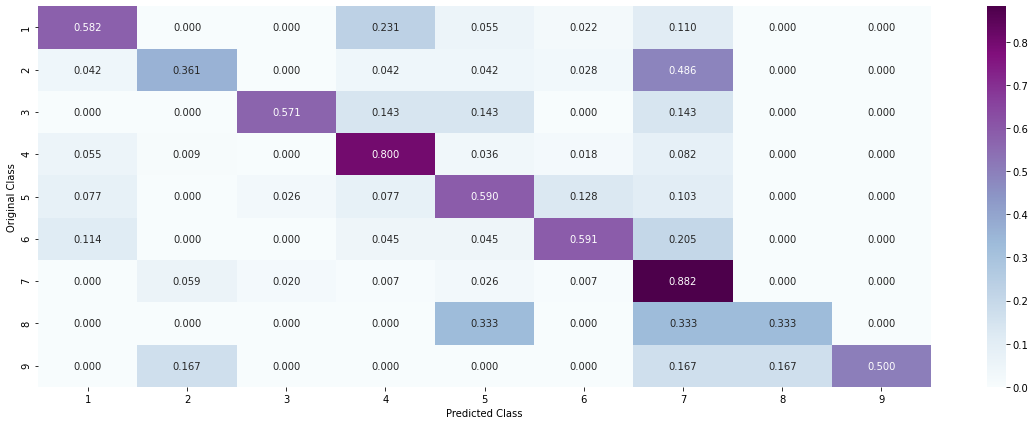

In [55]:
classifier = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
plot_CM(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, classifier)


##### Feature Importance, Correctly classified points


In [56]:
#CORRECTLY CLASSIFIED
classifier = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
classifier.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 1
Predicted Class Probabilities: [[6.019e-01 1.340e-02 8.000e-04 1.631e-01 1.831e-01 1.950e-02 1.190e-02
  5.500e-03 6.000e-04]]
Actual Class : 1

258 Text feature here is[xrcc1] present in the test data point [True]
555 Text feature here is[unfolded] present in the test data point [True]
703 Text feature here is[ln] present in the test data point [True]
736 Text feature here is[immobilized] present in the test data point [True]
828 Text feature here is[chymotrypsin] present in the test data point [True]
830 Text feature here is[valuable] present in the test data point [True]
934 Text feature here is[destabilized] present in the test data point [True]
At the query point 1000  number of features and word  7


##### Feature Importance, Incorrectly classified points


In [57]:
#INCORRECTLY CLASSIFIED
test_point_index = 5
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.coef_)[predicted_class-1][:,:n]
print("")
get_ftnames(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[2.900e-03 3.200e-03 2.000e-04 9.816e-01 2.900e-03 6.000e-04 7.000e-04
  7.700e-03 1.000e-04]]
Actual Class : 4

165 Text feature here is[mobilization] present in the test data point [True]
214 Text feature here is[araf] present in the test data point [True]
233 Text feature here is[erbitux] present in the test data point [True]
288 Text feature here is[homologues] present in the test data point [True]
375 Text feature here is[gm] present in the test data point [True]
385 Text feature here is[surely] present in the test data point [True]
399 Text feature here is[analysed] present in the test data point [True]
403 Text feature here is[critically] present in the test data point [True]
444 Text feature here is[come] present in the test data point [True]
460 Text feature here is[degradation] present in the test data point [True]
478 Text feature here is[endogenous] present in the test data point [True]
480 Text feature here is[familial] p

## RANDOM FOREST CLASSIFIER

##### With Onehot Coding:

n estimators = 100 and max depth =  5
Log Loss : 1.303045851361777
n estimators = 100 and max depth =  10
Log Loss : 1.1919428392633664

n estimators = 200 and max depth =  5
Log Loss : 1.287452373997596
n estimators = 200 and max depth =  10
Log Loss : 1.1747985528433702

n estimators = 500 and max depth =  5
Log Loss : 1.2832040741998547
n estimators = 500 and max depth =  10
Log Loss : 1.1678676524473506

n estimators = 1000 and max depth =  5
Log Loss : 1.2823521204642667
n estimators = 1000 and max depth =  10
Log Loss : 1.1678412878619293

n estimators = 2000 and max depth =  5
Log Loss : 1.2835375588000313
n estimators = 2000 and max depth =  10
Log Loss : 1.1672505902856143



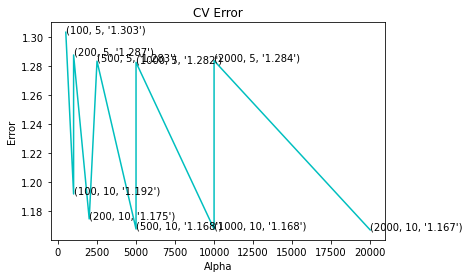

For values of best estimator =  2000

The train log loss is: 0.6247613213043437
The cross validation log loss is: 1.1672505902856145
The test log loss is: 1.1370734606068866


In [58]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("n estimators =", i,"and max depth = ", j)
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(train_x_onehotCoding, train_y)
        sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
        sigmoid_classifier.fit(train_x_onehotCoding, train_y)
        sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs)) 
    print("")
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))

plt.title("CV Error")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
classifier = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)

print('For values of best estimator = ', alpha[int(best_alpha/2)])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))


Log loss =  1.1672505902856143
Points that were mis-classified : 0.39097744360902253

Confusion matrix


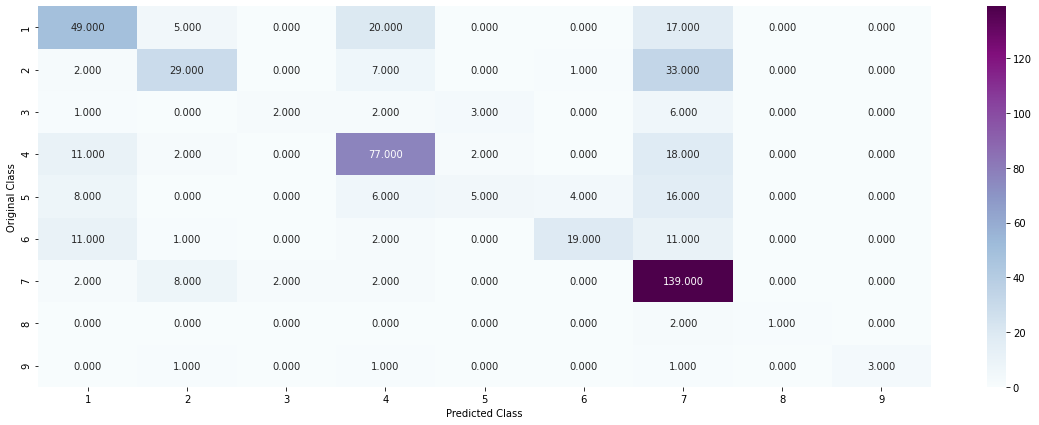

Precision matrix (Columm Sum=1)


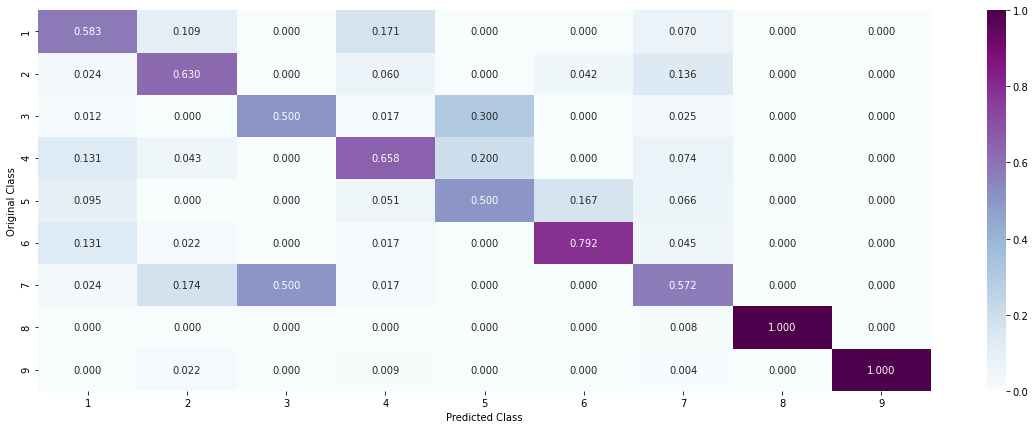

Recall matrix (Row sum=1)


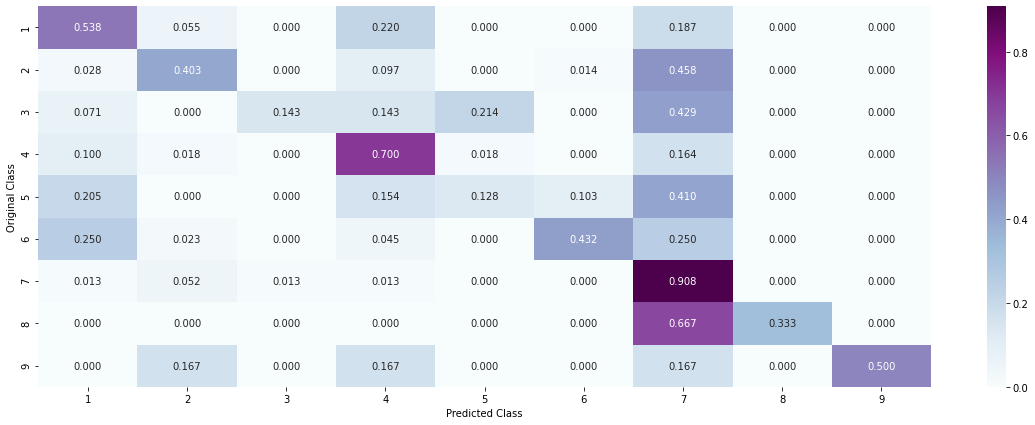

In [59]:
classifier = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
plot_CM(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, classifier)


##### Feature Importance, Correctly classified points


In [60]:
classifier = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
classifier.fit(train_x_onehotCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(clf, method="sigmoid")
sigmoid_classifier.fit(train_x_onehotCoding, train_y)

test_point_index = 1
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.feature_importances_)
print("")
get_ftnames(indices[:n], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 1
Predicted Class Probabilities: [[6.019e-01 1.340e-02 8.000e-04 1.631e-01 1.831e-01 1.950e-02 1.190e-02
  5.500e-03 6.000e-04]]
Actual Class : 1

2 Text feature here is[activating] present in the test data point [True]
3 Text feature here is[kinase] present in the test data point [True]
6 Text feature here is[activation] present in the test data point [True]
7 Text feature here is[phosphorylation] present in the test data point [True]
8 Text feature here is[constitutive] present in the test data point [True]
12 Text feature here is[suppressor] present in the test data point [True]
13 Text feature here is[missense] present in the test data point [True]
16 Text feature here is[function] present in the test data point [True]
26 Text feature here is[signaling] present in the test data point [True]
27 Text feature here is[loss] present in the test data point [True]
31 Text feature here is[clinical] present in the test data point [True]
32 Text feature here is[defective] p

266 Text feature here is[repeat] present in the test data point [True]
268 Text feature here is[levels] present in the test data point [True]
273 Text feature here is[positive] present in the test data point [True]
274 Text feature here is[leading] present in the test data point [True]
275 Text feature here is[time] present in the test data point [True]
278 Text feature here is[agvgd] present in the test data point [True]
283 Text feature here is[1863] present in the test data point [True]
285 Text feature here is[conserved] present in the test data point [True]
288 Text feature here is[bind] present in the test data point [True]
289 Text feature here is[substitutions] present in the test data point [True]
291 Text feature here is[binding] present in the test data point [True]
295 Text feature here is[compared] present in the test data point [True]
299 Text feature here is[splicing] present in the test data point [True]
301 Text feature here is[domain] present in the test data point [T

491 Text feature here is[increase] present in the test data point [True]
493 Text feature here is[studied] present in the test data point [True]
496 Text feature here is[76] present in the test data point [True]
497 Text feature here is[significantly] present in the test data point [True]
498 Text feature here is[pedigree] present in the test data point [True]
499 Text feature here is[including] present in the test data point [True]
500 Text feature here is[majority] present in the test data point [True]
502 Text feature here is[research] present in the test data point [True]
503 Text feature here is[according] present in the test data point [True]
504 Text feature here is[acid] present in the test data point [True]
505 Text feature here is[seeded] present in the test data point [True]
506 Text feature here is[24] present in the test data point [True]
507 Text feature here is[different] present in the test data point [True]
508 Text feature here is[genes] present in the test data point

681 Text feature here is[biochemical] present in the test data point [True]
684 Text feature here is[regulatory] present in the test data point [True]
685 Text feature here is[essential] present in the test data point [True]
686 Text feature here is[level] present in the test data point [True]
688 Text feature here is[given] present in the test data point [True]
689 Text feature here is[genetics] present in the test data point [True]
691 Text feature here is[address] present in the test data point [True]
692 Text feature here is[mutagenesis] present in the test data point [True]
693 Text feature here is[involved] present in the test data point [True]
696 Text feature here is[stably] present in the test data point [True]
698 Text feature here is[described] present in the test data point [True]
699 Text feature here is[made] present in the test data point [True]
700 Text feature here is[extremely] present in the test data point [True]
702 Text feature here is[forms] present in the test d

923 Text feature here is[ratio] present in the test data point [True]
926 Text feature here is[fraction] present in the test data point [True]
927 Text feature here is[high] present in the test data point [True]
928 Text feature here is[provide] present in the test data point [True]
929 Text feature here is[lead] present in the test data point [True]
930 Text feature here is[comparison] present in the test data point [True]
932 Text feature here is[direct] present in the test data point [True]
936 Text feature here is[contribute] present in the test data point [True]
939 Text feature here is[therefore] present in the test data point [True]
941 Text feature here is[v1736a] present in the test data point [True]
942 Text feature here is[generated] present in the test data point [True]
945 Text feature here is[critical] present in the test data point [True]
948 Text feature here is[able] present in the test data point [True]
950 Text feature here is[driven] present in the test data point [

##### Feature Importance, Incorrectly classified points


In [61]:
test_point_index = 5
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.feature_importances_)
print("")
get_ftnames(indices[:n], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[2.900e-03 3.200e-03 2.000e-04 9.816e-01 2.900e-03 6.000e-04 7.000e-04
  7.700e-03 1.000e-04]]
Actual Class : 4

0 Text feature here is[inhibitors] present in the test data point [True]
1 Text feature here is[activated] present in the test data point [True]
2 Text feature here is[activating] present in the test data point [True]
3 Text feature here is[kinase] present in the test data point [True]
4 Text feature here is[tyrosine] present in the test data point [True]
5 Text feature here is[treatment] present in the test data point [True]
6 Text feature here is[activation] present in the test data point [True]
7 Text feature here is[phosphorylation] present in the test data point [True]
8 Text feature here is[constitutive] present in the test data point [True]
9 Text feature here is[oncogenic] present in the test data point [True]
10 Text feature here is[inhibitor] present in the test data point [True]
11 Text feature here is[drug] pres

134 Text feature here is[metastatic] present in the test data point [True]
135 Text feature here is[nuclear] present in the test data point [True]
136 Text feature here is[membranes] present in the test data point [True]
137 Text feature here is[stimulation] present in the test data point [True]
138 Text feature here is[transformation] present in the test data point [True]
139 Text feature here is[12] present in the test data point [True]
140 Text feature here is[ability] present in the test data point [True]
141 Text feature here is[neutral] present in the test data point [True]
143 Text feature here is[activity] present in the test data point [True]
145 Text feature here is[kras] present in the test data point [True]
146 Text feature here is[pi3k] present in the test data point [True]
147 Text feature here is[defect] present in the test data point [True]
149 Text feature here is[acquired] present in the test data point [True]
154 Text feature here is[responses] present in the test da

313 Text feature here is[study] present in the test data point [True]
314 Text feature here is[fusion] present in the test data point [True]
315 Text feature here is[interaction] present in the test data point [True]
316 Text feature here is[mice] present in the test data point [True]
319 Text feature here is[previously] present in the test data point [True]
320 Text feature here is[confer] present in the test data point [True]
323 Text feature here is[transfection] present in the test data point [True]
324 Text feature here is[deficient] present in the test data point [True]
327 Text feature here is[values] present in the test data point [True]
328 Text feature here is[tissue] present in the test data point [True]
329 Text feature here is[combined] present in the test data point [True]
331 Text feature here is[elevated] present in the test data point [True]
332 Text feature here is[1a] present in the test data point [True]
333 Text feature here is[take] present in the test data point 

470 Text feature here is[ml] present in the test data point [True]
471 Text feature here is[21] present in the test data point [True]
472 Text feature here is[agents] present in the test data point [True]
474 Text feature here is[antibody] present in the test data point [True]
475 Text feature here is[introduction] present in the test data point [True]
476 Text feature here is[suggesting] present in the test data point [True]
477 Text feature here is[bcr] present in the test data point [True]
478 Text feature here is[important] present in the test data point [True]
479 Text feature here is[nih] present in the test data point [True]
481 Text feature here is[conformation] present in the test data point [True]
482 Text feature here is[specific] present in the test data point [True]
483 Text feature here is[point] present in the test data point [True]
484 Text feature here is[surface] present in the test data point [True]
485 Text feature here is[measure] present in the test data point [Tr

620 Text feature here is[express] present in the test data point [True]
621 Text feature here is[form] present in the test data point [True]
622 Text feature here is[degree] present in the test data point [True]
625 Text feature here is[60] present in the test data point [True]
626 Text feature here is[contains] present in the test data point [True]
627 Text feature here is[amino] present in the test data point [True]
628 Text feature here is[familial] present in the test data point [True]
629 Text feature here is[sequences] present in the test data point [True]
630 Text feature here is[four] present in the test data point [True]
631 Text feature here is[reported] present in the test data point [True]
634 Text feature here is[impair] present in the test data point [True]
635 Text feature here is[outside] present in the test data point [True]
636 Text feature here is[frequently] present in the test data point [True]
637 Text feature here is[diagnosis] present in the test data point [Tru

769 Text feature here is[identify] present in the test data point [True]
770 Text feature here is[rare] present in the test data point [True]
772 Text feature here is[96] present in the test data point [True]
773 Text feature here is[methods] present in the test data point [True]
774 Text feature here is[similarly] present in the test data point [True]
775 Text feature here is[overexpression] present in the test data point [True]
776 Text feature here is[showing] present in the test data point [True]
778 Text feature here is[analyses] present in the test data point [True]
779 Text feature here is[trisphosphate] present in the test data point [True]
780 Text feature here is[per] present in the test data point [True]
781 Text feature here is[development] present in the test data point [True]
783 Text feature here is[represent] present in the test data point [True]
784 Text feature here is[agent] present in the test data point [True]
785 Text feature here is[seen] present in the test data

916 Text feature here is[various] present in the test data point [True]
918 Text feature here is[range] present in the test data point [True]
919 Text feature here is[properties] present in the test data point [True]
921 Text feature here is[cdnas] present in the test data point [True]
922 Text feature here is[manner] present in the test data point [True]
923 Text feature here is[ratio] present in the test data point [True]
924 Text feature here is[tyr] present in the test data point [True]
925 Text feature here is[targeted] present in the test data point [True]
926 Text feature here is[fraction] present in the test data point [True]
927 Text feature here is[high] present in the test data point [True]
928 Text feature here is[provide] present in the test data point [True]
929 Text feature here is[lead] present in the test data point [True]
930 Text feature here is[comparison] present in the test data point [True]
931 Text feature here is[unique] present in the test data point [True]
93

##### With Response Coding:

n_estimators = 10 and max depth =  2
Log Loss : 2.081004195928639
n_estimators = 10 and max depth =  3
Log Loss : 1.6304966350014882
n_estimators = 10 and max depth =  5
Log Loss : 1.4232213453715683
n_estimators = 10 and max depth =  10
Log Loss : 1.6600634336522007
n_estimators = 50 and max depth =  2
Log Loss : 1.7487667337963084
n_estimators = 50 and max depth =  3
Log Loss : 1.4392867092266939
n_estimators = 50 and max depth =  5
Log Loss : 1.3310238044926843
n_estimators = 50 and max depth =  10
Log Loss : 1.608041402846358
n_estimators = 100 and max depth =  2
Log Loss : 1.5907640760354627
n_estimators = 100 and max depth =  3
Log Loss : 1.4936622440154677
n_estimators = 100 and max depth =  5
Log Loss : 1.2882232138516068
n_estimators = 100 and max depth =  10
Log Loss : 1.622004662365804
n_estimators = 200 and max depth =  2
Log Loss : 1.6156997879267427
n_estimators = 200 and max depth =  3
Log Loss : 1.5000851675230389
n_estimators = 200 and max depth =  5
Log Loss : 1.33612

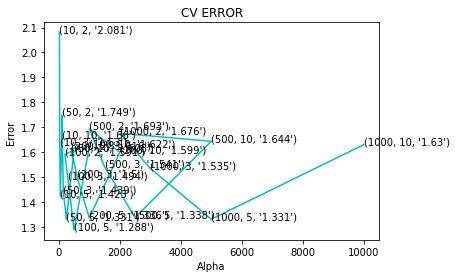

For values of best alpha =  100

The train log loss is: 0.06687202374696509
The cross validation log loss is: 1.2882232138516068
The test log loss is: 1.289782552408959


In [62]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("n_estimators =", i,"and max depth = ", j)
        classifier = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        classifier.fit(train_x_responseCoding, train_y)
        sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
        sigmoid_classifier.fit(train_x_responseCoding, train_y)
        sigmoid_classifier_probs = sigmoid_classifier.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sigmoid_classifier_probs, labels=classifier.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sigmoid_classifier_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))

plt.title("CV ERROR")
plt.xlabel("Alpha")
plt.ylabel("Error ")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
classifier = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
classifier.fit(train_x_responseCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_responseCoding, train_y)

print('For values of best alpha = ', alpha[int(best_alpha/4)])
print("")
predict_y = sigmoid_classifier.predict_proba(train_x_responseCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(cv_x_responseCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=classifier.classes_, eps=1e-15))
predict_y = sigmoid_classifier.predict_proba(test_x_responseCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=classifier.classes_, eps=1e-15))


Log loss =  1.2882232138516068
Points that were mis-classified : 0.462406015037594

Confusion matrix


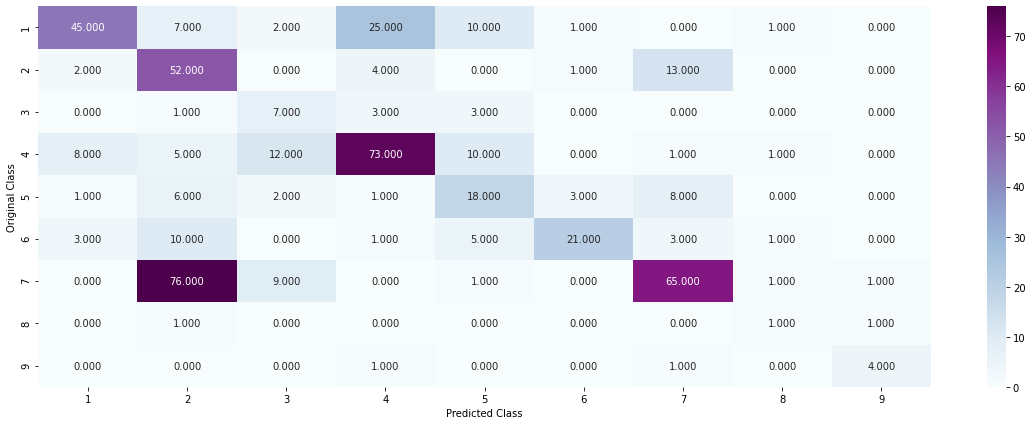

Precision matrix (Columm Sum=1)


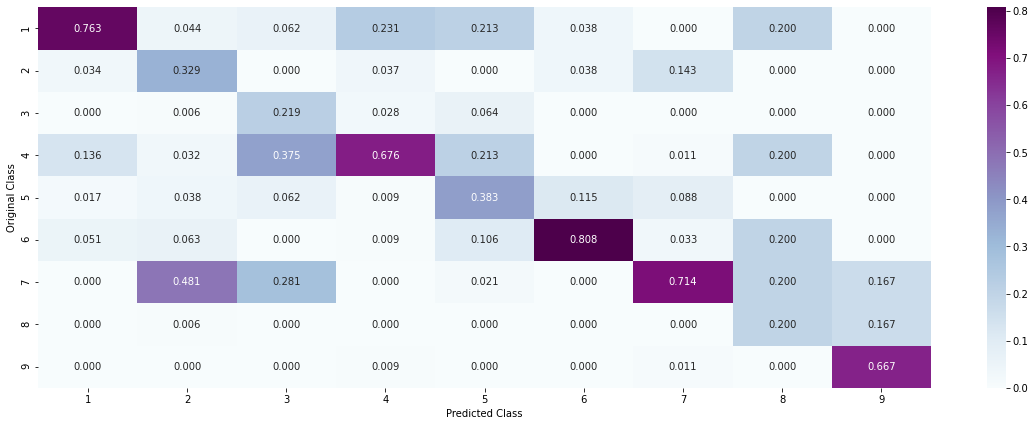

Recall matrix (Row sum=1)


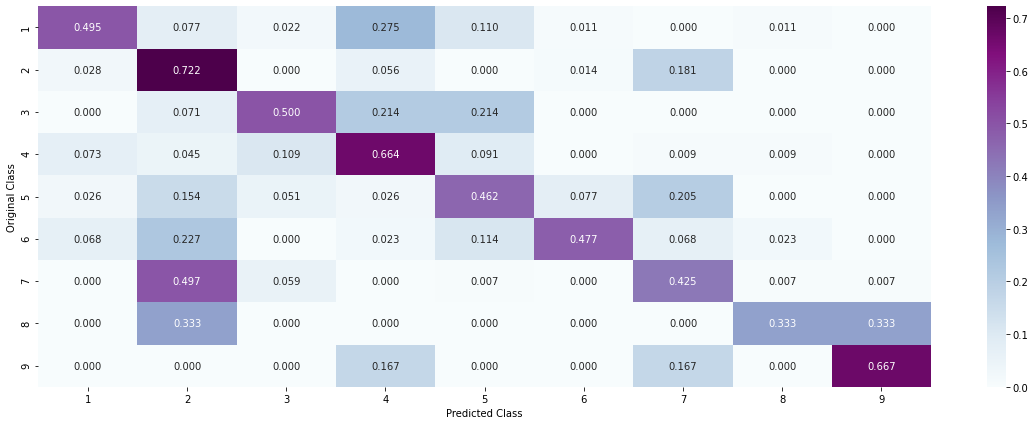

In [63]:
classifier = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
plot_CM(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, classifier)


##### Feature Importance, Correctly classified points


In [64]:
classifier = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
classifier.fit(train_x_responseCoding, train_y)
sigmoid_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sigmoid_classifier.fit(train_x_responseCoding, train_y)


test_point_index = 1
n = 1000
predicted_class = sigmoid_classifier.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.feature_importances_)
print("")
get_ftnames(indices[:n], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)

Predicted Class : 5
Predicted Class Probabilities: [[0.0753 0.0065 0.0539 0.0393 0.7197 0.0882 0.0039 0.0057 0.0075]]
Actual Class : 1

At the query point 1000  number of features and word  0


##### Feature Importance, Incorrectly classified points


In [65]:
#INCORRECTLY CLASSIFIED
n = 1000
test_point_index = 5
predicted_class = sigmoid_classifier.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(sigmoid_classifier.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-classifier.feature_importances_)
print("")
get_ftnames(indices[:n], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], n)


Predicted Class : 4
Predicted Class Probabilities: [[0.104  0.0428 0.1789 0.464  0.0552 0.0495 0.0232 0.0351 0.0474]]
Actual Class : 4

At the query point 1000  number of features and word  0


## STACK THE MODELS

In [66]:
# STACKING

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.02
Support vector machines : Log Loss: 1.45
Naive Bayes : Log Loss: 1.25
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.817
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.710
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.300
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.171
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.410
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.735


Log loss (train) on the stacking classifier : 0.47842897055540395
Log loss (CV) on the stacking classifier : 1.1710918547966858
Log loss (test) on the stacking classifier : 1.19553833835054
Number of missclassified point : 0.35789473684210527

Confusion matrix


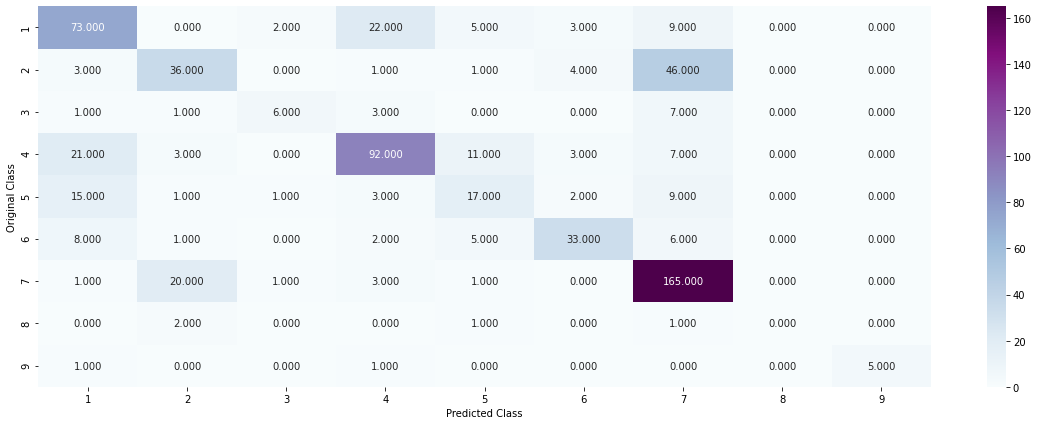

Precision matrix (Columm Sum=1)


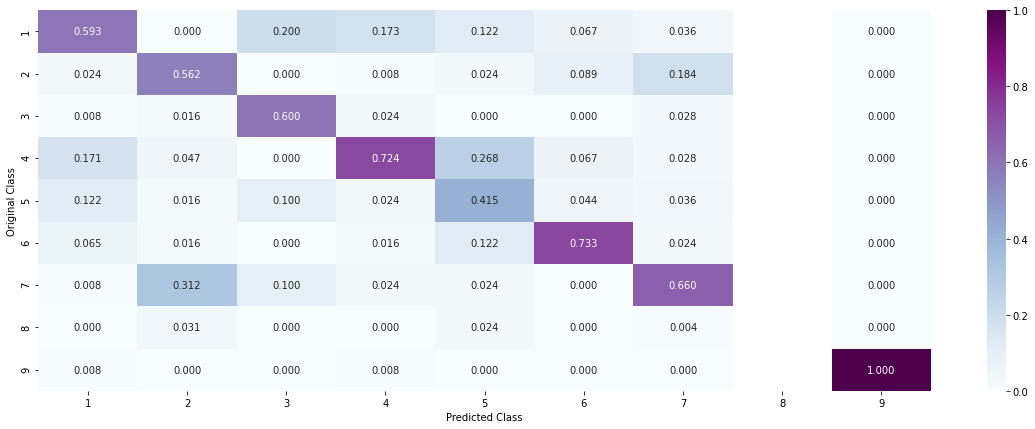

Recall matrix (Row sum=1)


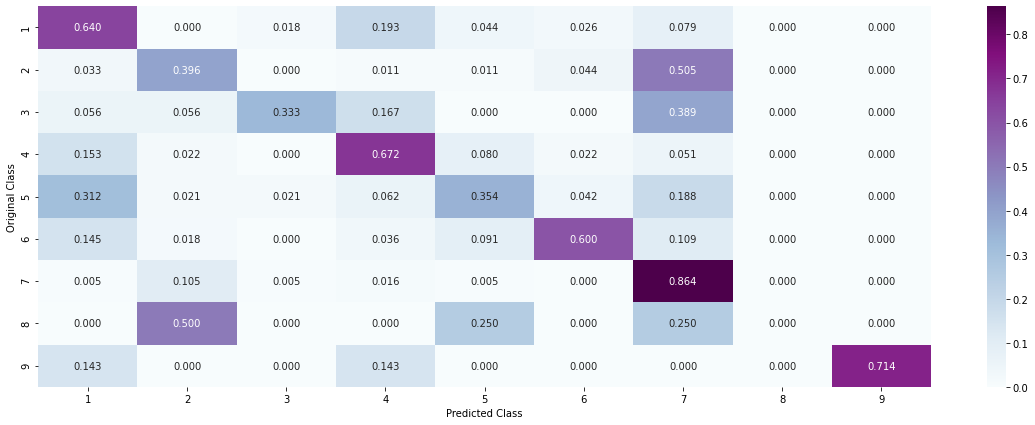

In [67]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
CM(test_y, sclf.predict(test_x_onehotCoding))


## MODEL SUMMARY

In [97]:
print()
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "Summary of all Models based on Log-Loss as the Performance Metric"
ptable.field_names=["Model Name","Train","CV","Test","% Misclassified Points"]
ptable.add_row(["Naive Bayes","0.84","1.03","1.27","33"])
ptable.add_row(["KNN","0.61","1.02","1.05","36"])
ptable.add_row(["Logistic Regression With Class balancing","0.48","1.01","1.07","33"])
ptable.add_row(["Logistic Regression Without Class balancing","0.45","1.03","1.07","33"])
ptable.add_row(["Linear SVM","0.44","1.03","1.07","32"])
ptable.add_row(["Random Forest Classifier With One hot Encoding","0.62","1.17","1.14","39"])
ptable.add_row(["Random Forest Classifier With Response Coding","0.07","1.29","1.29","46"])
ptable.add_row(["Stack Models:LR+NB+SVM","0.48","1.17","1.19","36"])
print(ptable)
print()


+-----------------------------------------------------------------------------------------------+
|               Summary of all Models based on Log-Loss as the Performance Metric               |
+------------------------------------------------+-------+------+------+------------------------+
|                   Model Name                   | Train |  CV  | Test | % Misclassified Points |
+------------------------------------------------+-------+------+------+------------------------+
|                  Naive Bayes                   |  0.84 | 1.03 | 1.27 |           33           |
|                      KNN                       |  0.61 | 1.02 | 1.05 |           36           |
|    Logistic Regression With Class balancing    |  0.48 | 1.01 | 1.07 |           33           |
|  Logistic Regression Without Class balancing   |  0.45 | 1.03 | 1.07 |           33           |
|                   Linear SVM                   |  0.44 | 1.03 | 1.07 |           32           |
| Random Forest Cla

##### Logistic Regression with class balancing proved to be the best choice among all the tested models.

In [69]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", cv_df))

In [70]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

# don't forget to normalize every feature
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [71]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", cv_df))

In [72]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

# don't forget to normalize every feature
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding, axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding, axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding, axis=0)

In [73]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 787297


In [74]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

# https://stackoverflow.com/a/16202486

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

# normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


In [75]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [76]:
print("ONE HOT ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_onehotCoding.shape)
print("Test dataset = ", test_x_onehotCoding.shape)
print("Cross Validation dataset =", cv_x_onehotCoding.shape)
print("")
print("RESPONSE ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_responseCoding.shape)
print("Test dataset = ", test_x_responseCoding.shape)
print("Cross Validation dataset =", cv_x_responseCoding.shape)

ONE HOT ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 789478)
Test dataset =  (665, 789478)
Cross Validation dataset = (532, 789478)

RESPONSE ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 27)
Test dataset =  (665, 27)
Cross Validation dataset = (532, 27)


For values of alpha =  1e-05 , The log loss is: 1.4472940125028944
For values of alpha =  0.0001 , The log loss is: 1.39967433938016
For values of alpha =  0.001 , The log loss is: 1.1991795541412251
For values of alpha =  0.01 , The log loss is: 1.1636286876006836
For values of alpha =  0.1 , The log loss is: 1.235678901253747
For values of alpha =  1 , The log loss is: 1.3076216463476327


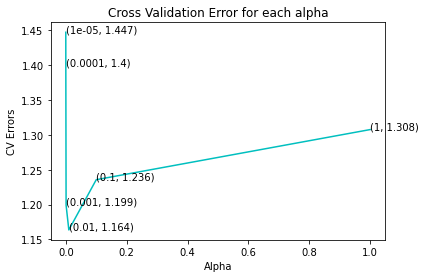

FOR BEST ALPHA VALUE =  0.01

The train log loss is: 0.665761022234525
The cross validation log loss is: 1.1636286876006836
0.01 The test log loss is: 1.1997147867185387


In [77]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ", The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("CV Errors")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)
print("FOR BEST ALPHA VALUE = ", alpha[best_alpha])
print("")
predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print(alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss =  1.150218156263739
Points that were mis-classified : 0.3684210526315789

Confusion matrix


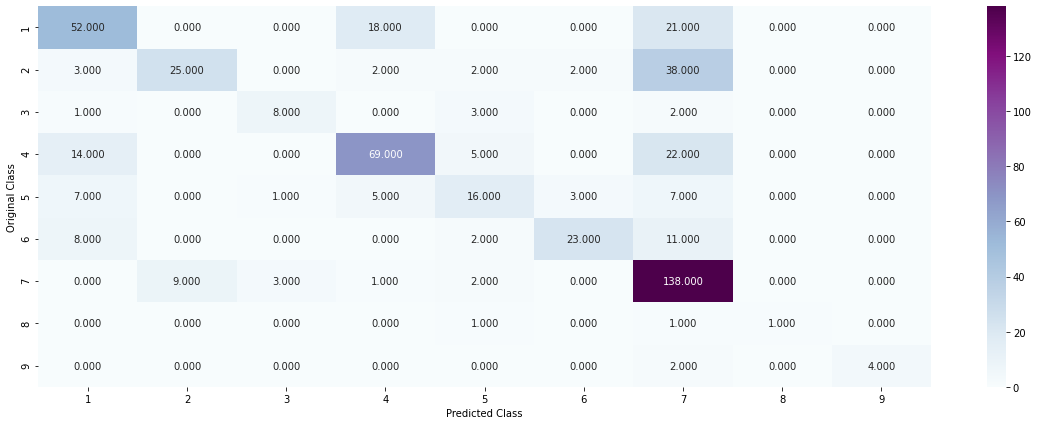

Precision matrix (Columm Sum=1)


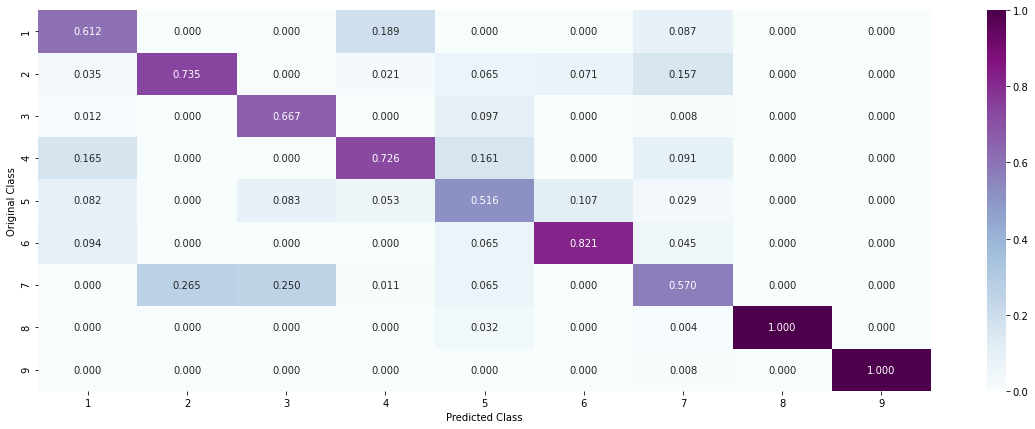

Recall matrix (Row sum=1)


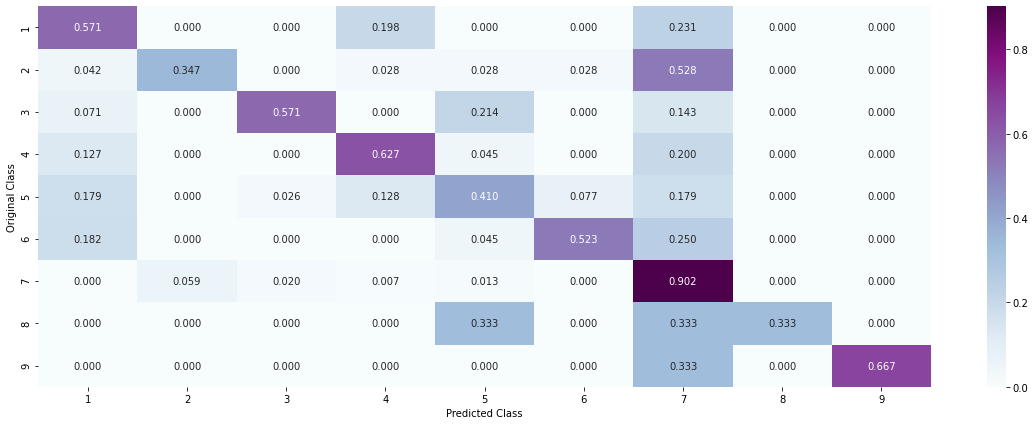

In [78]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
plot_CM(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

##### Lets apply feature engineering on the data and then apply logistic regression again

##### Lets merge gene and variation data into one list and apply TFidfVectorizer on top of it.

#### Gene Feature

In [79]:
merged = pd.merge(df, textdata, on='ID', how='left')
merged.loc[merged['TEXT'].isnull(),'TEXT'] = merged['Gene'] +' '+merged['Variation']

y_true = merged['Class'].values
merged.Gene      = merged.Gene.str.replace('\s+', '_')
merged.Variation = merged.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
train_df, test_df, y_train, y_test = train_test_split(merged, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(train_df, y_train, stratify=y_train, test_size=0.2)


In [80]:
def get_feature_dict(alpha, ft, df):
    val_ct = train_df[ft].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gvar_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, dr in val_ct.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[ft]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (dr + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gvar_dict[i]=vec
    return gvar_dict

# Get Gene variation feature
def get_feature(alpha, ft, df):
    gvar_dict = get_feature_dict(alpha, ft, df)
    # value_count is similar in get_gv_fea_dict
    val_ct = train_df[ft].value_counts()
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_feat = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[ft] in dict(val_ct).keys():
            gv_feat.append(gvar_dict[row[ft]])
        else:
            gv_feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_feat

In [81]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_feature(alpha, "Gene", cv_df))

In [82]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

#### Variation Feature

In [83]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_feature(alpha, "Variation", cv_df))

In [84]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

#### Text Feature

In [85]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [86]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer()
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 126599


In [87]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [88]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [89]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T


In [90]:
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

#### FEATURES AFTER FEATURE ENGINEERING

In [91]:
# Collecting all the genes and variations data into a single list
gene_variation = []

for gene in df['Gene'].values:
    gene_variation.append(gene)

for variation in df['Variation'].values:
    gene_variation.append(variation)

In [92]:
tfidfVectorizer = TfidfVectorizer(max_features=1000)
text2 = tfidfVectorizer.fit_transform(gene_variation)
gene_variation_features = tfidfVectorizer.get_feature_names()

train_text = tfidfVectorizer.transform(train_df['TEXT'])
test_text = tfidfVectorizer.transform(test_df['TEXT'])
cv_text = tfidfVectorizer.transform(cv_df['TEXT'])

In [93]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

# Adding the train_text feature
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text))
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

# Adding the test_text feature
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text))
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

# Adding the cv_text feature
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text))
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [94]:
print("ONE HOT ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_onehotCoding.shape)
print("Test dataset = ", test_x_onehotCoding.shape)
print("Cross Validation dataset =", cv_x_onehotCoding.shape)
print("")
print("RESPONSE ENCODING - (data points , no. of features) in:")
print("Train dataset = ", train_x_responseCoding.shape)
print("Test dataset = ", test_x_responseCoding.shape)
print("Cross Validation dataset =", cv_x_responseCoding.shape)

ONE HOT ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 128786)
Test dataset =  (665, 128786)
Cross Validation dataset = (532, 128786)

RESPONSE ENCODING - (data points , no. of features) in:
Train dataset =  (2124, 27)
Test dataset =  (665, 27)
Cross Validation dataset = (532, 27)


For values of alpha =  1e-05 , The log loss is: 1.0427591158229605
For values of alpha =  0.0001 , The log loss is: 1.0180269953149792
For values of alpha =  0.001 , The log loss is: 1.0964660954610006
For values of alpha =  0.01 , The log loss is: 1.2959539638426552
For values of alpha =  0.1 , The log loss is: 1.5460262502263002
For values of alpha =  1 , The log loss is: 1.6097161094168466


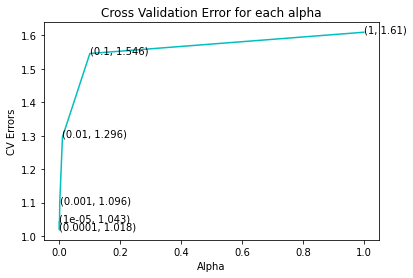

FOR BEST ALPHA VALUE =  0.0001

The train log loss is: 0.6549481328952977
The cross validation log loss is: 1.0180269953149792
0.0001 The test log loss is: 1.0291578429816486


In [95]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ", The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='c')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("CV Errors")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)
print("FOR BEST ALPHA VALUE = ", alpha[best_alpha])
print("")
predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print(alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss =  0.957181076919476
Points that were mis-classified : 0.33458646616541354

Confusion matrix


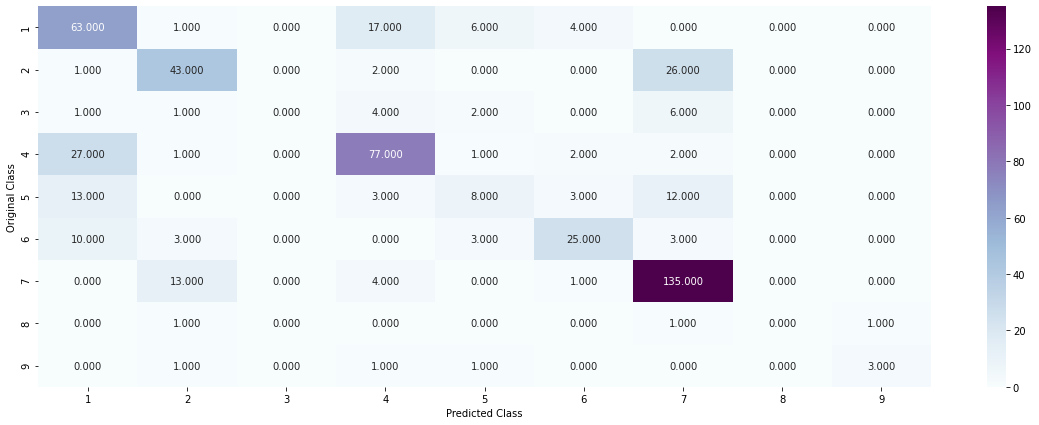

Precision matrix (Columm Sum=1)


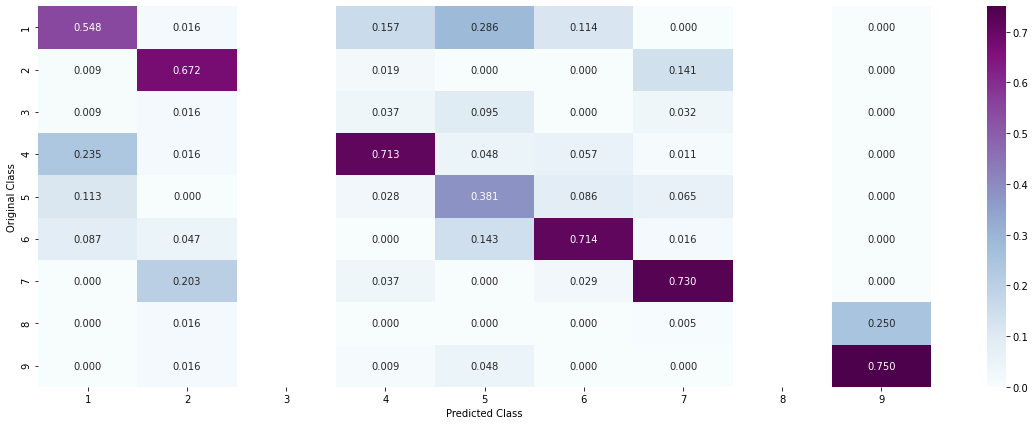

Recall matrix (Row sum=1)


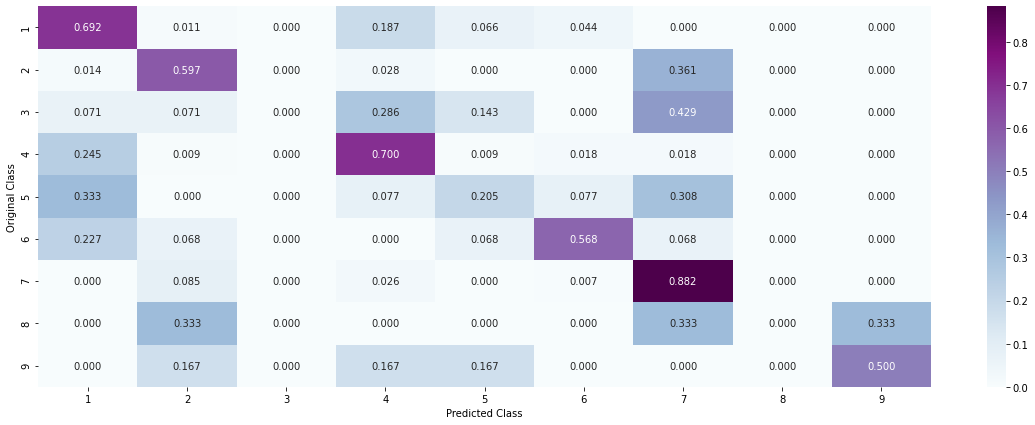

In [96]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
plot_CM(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Performing feature engineering reduced the log loss below 1. We can perform other feature engineering approaches to further reduce the log loss.